# FIT5196 Assessment 3
### Student Name: Vishal Pattabiraman
### Student ID: 31131441

#### Date: 18/11/2020

#### Version: 1.1

#### Environment: Python 3.8.5 and Jupyter notebook
***

## Library Import

In [269]:
#Basic scientific python libs
import pandas as pd # data frame etc.
import numpy as np # lin solve
import re # extract info from shopping cart using regex
import math # for Math calculations.
import datetime # extracting hours and minutes from time.
from datetime import timedelta
import geopandas as gpd # reading shape file and creting geopandas dataframe.
from shapely.geometry import Point, Polygon # to use spatial join and read shape file.
pd.options.mode.chained_assignment = None # to remove "chained" assignment warnings.
from scipy import stats # Box-cox transformation.

## 1. Load Dataset

In this section we will need to load data from different type of dataset provided to us. This includes reading files from :

>* Excel
>* XML
>* HTML
>* CSV
>* PDF

The following sections shows how data from these different file types are read into 
python and loaded using pandas and other library to store them in a pandas data frame. 


### 1.1 Import Hospital excel file

Hospital Excel file contains the information related to hospitals with their corresponding unique Hospital ID with corresponding Lattitude and Longitude of these hospitals. Using Pandas we will read the Excel file using **read_excel** function and store them onto a pandas dataframe **hospital_data**. 

In [194]:
# Read Excel file.
hospital_data = pd.read_excel('hospitals.xlsx')

Using **Head()** function we can check the top 6 rows of the dataframe that is created using read_excel function.

In [195]:
# Display columns and values
hospital_data.head()

,Unnamed: 0,id,lat,lng,name
0,0,hospital_001,-37.990622,145.072836,Como Private Hospital
1,1,hospital_002,-37.855469,145.268183,Mountain District Private Hospital
2,2,hospital_003,-37.792230,144.889128,Western Hospital
3,3,hospital_004,-37.756042,145.061896,Mercy Hospital for Women
4,4,hospital_005,-37.760623,144.815624,Sunshine Hospital


In order to perform any manipulation to this file, we need to understand the datatype of all the columns so that if any changes or conversion is required or needs to be performed. **info()** function helps to display datatypes of all the dataframe columns with number of entries which in this case is 199 rows with 5 rows.

In [196]:
# Check for datatypes
hospital_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 199 entries, 0 to 198
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Unnamed: 0  199 non-null    int64  
 1   id          199 non-null    object 
 2   lat         199 non-null    float64
 3   lng         199 non-null    float64
 4   name        199 non-null    object 
dtypes: float64(2), int64(1), object(2)
memory usage: 7.9+ KB


Describe() function comes handy to handle number type type data. This has builtin operation that shows the min, max, mean , Standard deviation, 25% , 50% and 75% quartiles of distribution of these columns. We will use this to see if there are any outliers. Clearly, the data here doesnt show any extereme values and standard deviation is between 0.63 and 0.84 for both lat and lng columns respectively.

In [197]:
# Check the excel_data count and stat information.
hospital_data.describe()

,Unnamed: 0,lat,lng
count,199.000000,199.000000,199.000000
mean,99.000000,-37.626508,144.931263
std,57.590508,0.630917,0.843463
min,0.000000,-38.658958,141.237173
25%,49.500000,-37.884990,144.957744
50%,99.000000,-37.812713,145.019380
75%,148.500000,-37.749116,145.144588
max,198.000000,-34.185351,148.000794


#### Preprocess Hospital data.

Although describe() function does provide information of the spread of all the columns, we are still not sure if these rows have 

1. Unnamed column is not required and needs to be pruned. 
2. Duplicated rows
3. Duplicated Lat and Lng
4. Check if Lattitude and Longitude provide for hospitals are within Victoria boundary.


In [198]:
# 1. we will drop the duplicated index. Unnamed: 0 column
hospital_data.drop(['Unnamed: 0'], axis=1, inplace=True)

Empty search result shows that there are no duplicated rows.

In [199]:
# 2. Check for duplicates in excel_data dataset.
hospital_data.loc[(hospital_data.duplicated()==True)]

,id,lat,lng,name


Exmpty search result shows that both Lat and Lng columns are not duplicated.

In [200]:
# 3. Check for lat and long duplicates.
hospital_data.loc[hospital_data['lat'].duplicated() & hospital_data['lng'].duplicated()]

,id,lat,lng,name


Using the information from [Wiki](https://en.wikipedia.org/wiki/Module:Location_map/data/Australia_Victoria) we know that Victoria state has the following boundaries **-33.8 top , -39.3 bottom ,140.6 left and 150.3 right**. In order to make sure that Hospital_data dataframe does not have hospital information that do not belong to **Victoria state** we will check this information with the lat and lng columns of Hospital_data. Empty search result shows that all the hospital information provided belong to Victoria state.

In [201]:
# 4. Check for invalid Hospital data Using Victoria Lat, Long 
# According to Wiki (-33.8 top, -39.3 bottom,140.6 left and 150.3 right) are Vic coordinates.

index= (hospital_data.lat<-39.3) | (hospital_data.lat>-33.8) | (hospital_data.lng<140.6) | (hospital_data.lng > 150.3)
hospital_data.loc[index]

,id,lat,lng,name


### 1.2 Import real_state xml file.

In this section we need to import information from the XML file real_state. This file contains data related to Real state property in Victoria state. Since this file is in XML format we will read the file using inbuilt file open and readline() function real_state data is read initially. Once we have this information, XML is stored in a particular format which will be exploited using Regex. 

In [202]:
# Read XML data
with open ("real_state.xml",encoding="UTF-8") as fd:
    xml_file=fd.readline() # read xml file


We can see that xml_file contain data in tags within **<>**. The columns, **'property_id','lat','lng','addr_street','price','property_type','year','bedrooms','bathrooms','parking_space'** are included into for instance, **<property_id type="dict">** which denotes the start of this column and **< //property_id>**denotes the end of this column. 

In [203]:
# Display the file.
xml_file

'b\'<?xml version="1.0" encoding="UTF-8" ?><root><property_id type="dict"><n55964 type="int">56499</n55964><n53194 type="int">53729</n53194><n79894 type="int">80429</n79894><n18375 type="int">18910</n18375><n52313 type="int">52848</n52313><n31479 type="int">32014</n31479><n83172 type="int">83707</n83172><n1349 type="int">1355</n1349><n37845 type="int">38380</n37845><n6929 type="int">6950</n6929><n48489 type="int">49024</n48489><n75687 type="int">76222</n75687><n40181 type="int">40716</n40181><n2854 type="int">2875</n2854><n82062 type="int">82597</n82062><n60945 type="int">61480</n60945><n30645 type="int">31180</n30645><n33174 type="int">33709</n33174><n34097 type="int">34632</n34097><n33046 type="int">33581</n33046><n51007 type="int">51542</n51007><n34018 type="int">34553</n34018><n22458 type="int">22993</n22458><n42143 type="int">42678</n42143><n2932 type="int">2953</n2932><n74910 type="int">75445</n74910><n84324 type="int">84859</n84324><n34276 type="int">34811</n34276><n78121 type="

In this section we will set up the overall frame what the real_state dataframe should look like, All the columns that are available in XML is used to create this dataframe.

In [204]:
# Dataframe to store xml data.
real_state_xml=pd.DataFrame(columns=['property_id','lat','lng','addr_street','price','property_type','year','bedrooms','bathrooms','parking_space'])

It is important to note that based on understand of data we found that each **property** in the XML is unique and a single row has 'property_id','lat','lng','addr_street','price','property_type','year','bedrooms','bathrooms','parking_space' with this unique property ID value. Knowing this information we will extract all the Property Id separately using the regex shown below. This regex helps to anything that is within <property_id type="dict"> start tag to <//property_id>  end tag. Once we have this information, we could see that for instance **<**n55964 type="int"**>**56499**<**/n55964**>**  has the property id number embedded inside the end tag </n**55964**> highlighted. Again using Regular expression </n(\d+)> we extract all digits that are 1 or more into id_raw list. 

In [205]:
# obtain row Id from XML id. 
id_dump=re.findall(r'<property_id type="dict">(.*?)</property_id>',xml_file)
# Convert to string.
id_dump=str(id_dump)
# store row ids.
id_raw=re.findall(r'</n(\d+)>',id_dump)

id_raw shows all the extracted proeprty id that will be used to fetch information of all the other columns

In [206]:
# Ids of Rows
id_raw

['55964',
 '53194',
 '79894',
 '18375',
 '52313',
 '31479',
 '83172',
 '1349',
 '37845',
 '6929',
 '48489',
 '75687',
 '40181',
 '2854',
 '82062',
 '60945',
 '30645',
 '33174',
 '34097',
 '33046',
 '51007',
 '34018',
 '22458',
 '42143',
 '2932',
 '74910',
 '84324',
 '34276',
 '78121',
 '40747',
 '42651',
 '42285',
 '24756',
 '9212',
 '25155',
 '71461',
 '13179',
 '20495',
 '85888',
 '55302',
 '87301',
 '74779',
 '72186',
 '54936',
 '80840',
 '17708',
 '63793',
 '78950',
 '94076',
 '44199',
 '46450',
 '25642',
 '17445',
 '37463',
 '49246',
 '43000',
 '30799',
 '16913',
 '8300',
 '13698',
 '26493',
 '80563',
 '10170',
 '6084',
 '12087',
 '7892',
 '40017',
 '35953',
 '47492',
 '50616',
 '85160',
 '60832',
 '11887',
 '76266',
 '56569',
 '11366',
 '14343',
 '7102',
 '72077',
 '63549',
 '29840',
 '16673',
 '7668',
 '1430',
 '22494',
 '73602',
 '85074',
 '74269',
 '92528',
 '87597',
 '61494',
 '31420',
 '31662',
 '55389',
 '45286',
 '18498',
 '8205',
 '13879',
 '93633',
 '94542',
 '19827',
 '

**[Image](https://regexper.com/#%3Cn%7Bitem%7D%20type%3D%22%28%3F%3Aint%7Cstr%7Cfloat%29%22%3E%28.*%3F%29%3C%5C%2Fn%7Bitem%7D%3E)** shows how this regualar expression works in a detailed manner. The essence is that we check for all items with property id in the format inside <n> tag with type= int or str or float. We extract the value using (.*?) and store this information into the pandas dataframe. Since we know for a single property there are values for 'property_id','lat','lng','addr_street','price','property_type','year','bedrooms','bathrooms','parking_space' using the loop we extract information for each column one by one and store into corresponing pandas columns.

In [207]:
# Increment the index and append rows to dataframe.
i=1 # index value
for item in id_raw:
    # search through xml_file and get corresponding row data.
    trans_value=re.findall(rf'<n{item} type="(?:int|str|float)">(.*?)</n{item}>',xml_file)
    # append data to dataframe.
    real_state_xml.loc[i]=trans_value
    i+=1 # increment index

once column information is extracted from the XML we display the pandas data frame which contains information of real_state.

In [208]:
# display xml_data
real_state_xml

,property_id,lat,lng,addr_street,price,property_type,year,bedrooms,bathrooms,parking_space
1,56499,-37.84466934,145.108963,28 Kildare Street,8060000,house,2008,5,2,2
2,53729,-37.82271957,145.01028440000002,73 Stawell Street,7448000,house,2009,2,1,1
3,80429,-38.005026,145.14828799999998,63 Marriott Drive,5880000,house,2013,3,2,2
4,18910,-37.685,144.93151799999998,47 Cuthbert Street,3520000,house,2016,3,1,0
5,52848,-37.82897949,145.002182,269 Coppin Street,14300000,house,2008,3,1,2
...,...,...,...,...,...,...,...,...,...,...
1002,32245,-37.73400116,145.00254819999998,20 Olver Street,6400000,house,2009,4,2,2
1003,27356,-37.602644,144.932319,6 Clacton Court,5746000,house,2012,3,1,1
1004,92382,-37.97805,145.06831699999998,61 Nepean Highway,6000000,house,2011,2,1,3
1005,59692,-37.82458115,145.1892395,24 Lucknow Street,2240000,house,2009,3,1,2


#### Preprocess real_state_xml data

Although we have extracted the XML data into pandas dataframe there are chances that we might have erros and issues with the rows and columns of this dataframe. We will check for:

1. Duplicated Property ID
2. Duplicated Lattitude and Longitude.
3. Check if Lattitude and Longitude provide for Properties are within Victoria boundary.

Empty search result shows that there no duplicated Property ID in xml_data

In [209]:
# 1. Check for duplicate value in xml_data
# ~ is for False.
real_state_xml.loc[real_state_xml['property_id'].duplicated()]

,property_id,lat,lng,addr_street,price,property_type,year,bedrooms,bathrooms,parking_space


Empty search result shows that there no duplicated lattitude or longitude in xml_data

In [210]:
# 2. Duplicated lat and long
real_state_xml.loc[real_state_xml['lat'].duplicated() & real_state_xml['lng'].duplicated()]

,property_id,lat,lng,addr_street,price,property_type,year,bedrooms,bathrooms,parking_space


As explained for the Hospital_data, we use the latitude information provide in Wikipedia for Victoria state and check if there are any properties that are outside Victoria state. Empty search result shows that there are not properties that are outside Victoria state.

In [211]:
# 3. Check for invalid real_state_xml data Using Victoria Lat, Long 
# According to Wiki (-33.8 top, -39.3 bottom,140.6 left and 150.3 right) are Vic coordinates.
index= (real_state_xml.lat.astype(float)<-39.3) | (real_state_xml.lat.astype(float)>-33.8) | (real_state_xml.lng.astype(float)<140.6) | (real_state_xml.lng.astype(float) > 150.3)
real_state_xml.loc[index]

,property_id,lat,lng,addr_street,price,property_type,year,bedrooms,bathrooms,parking_space


### 1.3 Import real_state Json file

In this section we will import the information from JSON file. Here we will use pandas read_json() function, which can read json file and provide a pandas dataframe. Here we store the pandas dataframe as real_state_json and display the column values as shown below. Also it is important to note that we need one amalgamated dataframe that contains information about all real_state_properties from XML and JSON file. 

In [212]:
# read json file and store as dataframe.
real_state_json=pd.read_json('real_state.json')
# display json dataframe.
real_state_json

,property_id,lat,lng,addr_street,price,property_type,year,bedrooms,bathrooms,parking_space
0,57644,-37.812511,145.158310,14 Larch Street,6300000,house,2008,2,1,1
1,46437,-37.695589,145.153953,11 Balmoral Circuit,5840000,house,2015,4,2,3
2,57752,-37.812518,145.164660,1A Goodwin Street,10500000,house,2014,2,1,1
3,77357,-37.933558,145.165106,1/4 Dendy Court,6682000,house,2015,2,1,1
4,18162,-37.673559,144.919102,132 Riggall Street,2224000,house,2013,3,1,2
...,...,...,...,...,...,...,...,...,...,...
1005,22334,-37.737273,144.980359,23 Connolly Avenue,3510000,house,2009,2,1,1
1006,38977,-37.760033,145.038101,61 Hawker Street,9010000,house,2009,3,1,1
1007,57112,-37.831810,145.084616,196 Prospect Hill Road,12000000,house,2010,4,1,0
1008,52962,-37.815549,144.991901,3 Muir Street,24480000,house,2012,4,3,2


#### Preprocess real_state_json data

Although we have extracted the JSON data into pandas dataframe there are chances that we might have erros and issues with the rows and columns of this dataframe. We will check for:

1. Duplicated property_ID
2. Duplicated Latitude and Longitude
3. Check if Lattitude and Longitude provide for Properties are within Victoria boundary.

We can see that there are 7 duplicated rows with same property ID which is has the same information repeated twice. This means that it doesnt matter if we remove the first row or the second row we do not lose any information. In this case duplicates are dropped while keeping the first entry of that property id. Using duplicated() function we can check for rows which have the same property id.

In [213]:
# 1. check for duplicated propertyID.
real_state_json.loc[real_state_json['property_id'].duplicated()]

,property_id,lat,lng,addr_street,price,property_type,year,bedrooms,bathrooms,parking_space
293,69903,-37.867483,145.096576,3/18 May Park Avenue,10928000,house,2010,3,2,2
299,25481,-37.607861,144.917969,15 Elmwood Place,5200000,house,2009,3,2,2
494,33161,-37.732835,144.993182,73 May Street,9520000,house,2013,2,1,2
657,12110,-37.697677,144.758339,10 Kontek Way,5160000,house,2014,4,2,2
732,10074,-37.790990,144.925905,14 Percy Street,6300000,house,2013,2,1,0
883,87430,-37.935301,145.021282,174 Ludstone Street,15750000,house,2013,4,2,1
885,16790,-37.699725,144.922128,206 Hilton Street,7154000,house,2014,3,1,2


The below code chunk shows a sample property id 69903 which is duplicated with same value accross all rows.

In [214]:
# 1. Display one duplicated Property.
real_state_json.loc[real_state_json.property_id==69903]

,property_id,lat,lng,addr_street,price,property_type,year,bedrooms,bathrooms,parking_space
165,69903,-37.867483,145.096576,3/18 May Park Avenue,10928000,house,2010,3,2,2
293,69903,-37.867483,145.096576,3/18 May Park Avenue,10928000,house,2010,3,2,2


In this section we will drop the second occurence of the same property id entry using **drop_duplicates()** funtions. In this function we will specify the parameters keep='first' to denote which record needs to be dropped.

In [215]:
# 1. remove duplicated records and keep first one.
real_state_json.drop_duplicates(['property_id'], keep='first', inplace=True)

Empty search result shows that there are no duplicated lattitude and longitude, in other words no two properties have the same lattitude and longitude. 

In [216]:
# 2. duplicated lat and long
real_state_json.loc[real_state_json['lat'].duplicated() & real_state_json['lng'].duplicated()]

,property_id,lat,lng,addr_street,price,property_type,year,bedrooms,bathrooms,parking_space


Empty search result shows that there are no properties that are outside **Victoria state**. We need to make sure about this information as data manipulations that will be done below corresponds to properties that are inside Victoria state.

In [217]:
# 3. Check for invalid real_state_json data Using Victoria Lat, Long 
# According to Wiki (-33.8 top, -39.3 bottom,140.6 left and 150.3 right) are Vic coordinates.
index= (real_state_json.lat.astype(float)<-39.3) | (real_state_json.lat.astype(float)>-33.8) | (real_state_json.lng.astype(float)<140.6) | (real_state_json.lng.astype(float) > 150.3)
real_state_json.loc[index]

,property_id,lat,lng,addr_street,price,property_type,year,bedrooms,bathrooms,parking_space


### 1.4 Merge realstate data to one dataframe

We need to have one amalgamated dataframe that contains data from both the XML and JSON files. So in this section we will merge these two files into one pandas dataframe **real_state_data**. In order accomplish this we will use concat() function that is contatinates information from real_state_xml and real_state_json into one single pandas container. 

In [218]:
# Store real_state data from json and xml to one dataframe
real_state_data= pd.concat([real_state_xml,real_state_json])

In [219]:
# convert lat and long to float as to make comparision.
real_state_data['lat']=real_state_data['lat'].astype(float)
real_state_data['lng']= real_state_data['lng'].astype(float)

In [220]:
# display realstate data.
real_state_data

,property_id,lat,lng,addr_street,price,property_type,year,bedrooms,bathrooms,parking_space
1,56499,-37.844669,145.108963,28 Kildare Street,8060000,house,2008,5,2,2
2,53729,-37.822720,145.010284,73 Stawell Street,7448000,house,2009,2,1,1
3,80429,-38.005026,145.148288,63 Marriott Drive,5880000,house,2013,3,2,2
4,18910,-37.685000,144.931518,47 Cuthbert Street,3520000,house,2016,3,1,0
5,52848,-37.828979,145.002182,269 Coppin Street,14300000,house,2008,3,1,2
...,...,...,...,...,...,...,...,...,...,...
1005,22334,-37.737273,144.980359,23 Connolly Avenue,3510000,house,2009,2,1,1
1006,38977,-37.760033,145.038101,61 Hawker Street,9010000,house,2009,3,1,1
1007,57112,-37.831810,145.084616,196 Prospect Hill Road,12000000,house,2010,4,1,0
1008,52962,-37.815549,144.991901,3 Muir Street,24480000,house,2012,4,3,2


#### Preprocess real_state_data information.

Although we have performed preprocessing to both real_state_xml and real_state_json dataframes separately, we are still not sure if there are issues and anamolies that may have occured in the contatinated dataframe. We will check for :

1. Duplicated PropertyID
2. Duplicated Latitude, Longitude and Price.

Here we dont look for duplicated lattitude and longitude it is possible that there might be different units within the same property that are being sold. At this point we need to check only for duplicated property ids.

Empty values shows that there are no duplicated properties in the real_state_data information.

In [221]:
# 1. check if duplicates in json and xml combined.
real_state_data.loc[real_state_data['property_id'].duplicated()==True]

,property_id,lat,lng,addr_street,price,property_type,year,bedrooms,bathrooms,parking_space


In [222]:
# 2. check if a property with same lat and long is sold for same price.
# This is so that we dont sell the same property with different property ID
real_state_data.loc[real_state_data[['lat','lng','price']].duplicated()==True]

,property_id,lat,lng,addr_street,price,property_type,year,bedrooms,bathrooms,parking_space


### 1.5 Import supermarkets HTML file.

In this section we will read the information from HTML file using the pandas in built function read_html that extracts information from supermarkets.html file and returns a list of column information. Since we need a pandas dataframe we will use the index 0 to store it into supermarket_data data frame.

In [223]:
# Read Html data.
html_file=pd.read_html('supermarkets.html')
# html_file is a list so taking first element which contains columns infromation.
supermarket_data=html_file[0]
# display supermarket_data
supermarket_data

,Unnamed: 0,id,lat,lng,type
0,0,S_001,-37.883978,144.735287,Woolworths
1,1,S_002,-41.161591,147.514797,Woolworths
2,2,S_003,-37.984078,145.077167,Woolworths
3,3,S_004,-37.707023,144.938740,Woolworths
4,4,S_005,-37.597670,144.938413,Woolworths
...,...,...,...,...,...
234,234,S_235,-37.860188,145.028920,Coles
235,235,S_236,-37.875984,144.614490,Coles
236,236,S_237,-37.047330,143.744610,Coles
237,237,S_238,-38.351648,144.922881,Coles


#### Preprocess supermarket_data dataframe.

The information extract from HTML file may contains errors and other issues which needs to be identified and fixed before this dataframe can be used for manipulations. We will check for the following anamolies:

1. Remove Unnamed column.
2. Check for duplicated id.
3. Duplicated Lattitude and Longitude.
4. check if supermarkets are inside Victoria state.

The below code will drop the Unnamed column which is the default index that is not required.

In [224]:
# 1. we will drop the duplicated index. Unnamed: 0 column
supermarket_data.drop(['Unnamed: 0'], axis=1, inplace=True)

Empty search result shows that there are no duplicated Supermarket with same ID

In [225]:
# 2. check for duplicates
supermarket_data.loc[supermarket_data['id'].duplicated()==True]

,id,lat,lng,type


We can see that there are two super markets with ids S_226 and S_227 which have the same lattitude and longitude that needs to be removed as this is a duplicated Coles market with same Lattitude and Longitude but different Id. 

In [226]:
# 3. check for lat and long duplicated record.
supermarket_data.loc[supermarket_data[['lat','lng']].duplicated()]

,id,lat,lng,type
226,S_227,-37.86685,145.2204,Coles


In [227]:
# 3. Drop lat and lng duplicated.
supermarket_data.drop_duplicates(['lat','lng'], keep='first', inplace=True)

The below code shows SuperMarkets that <font color=Red>**do not belong Victoria state**</font>. We need to clean these columns and remove them before performing any manupulations further on.

In [228]:
# 4. Check for invalid supermarket_data data Using Victoria Lat, Long 
# According to Wiki (-33.8 top, -39.3 bottom,140.6 left and 150.3 right) are Vic coordinates.
index= (supermarket_data.lat.astype(float)<-39.3) | (supermarket_data.lat.astype(float)>-33.8) | (supermarket_data.lng.astype(float)<140.6) | (supermarket_data.lng.astype(float) > 150.3)
# Display Supermarkets that are not inside Victories State.
supermarket_data.loc[index]

,id,lat,lng,type
1,S_002,-41.161591,147.514797,Woolworths
64,S_065,-35.552942,138.619966,Woolworths
88,S_089,-31.973481,115.898108,Woolworths
119,S_120,-33.798090,151.182880,Coles
120,S_121,-33.800770,151.179600,Coles
121,S_122,-33.710530,150.951140,Coles
122,S_123,-33.996387,150.890010,Coles
123,S_124,-33.808617,151.005340,Coles
124,S_125,-21.142496,149.182140,Coles
125,S_126,-27.594612,153.273270,Coles


We can see there are 11 rows with supermarkets that are not inside Victoria state. These will be removed using the '~' which denote the negation. The code below identifies rows that do not satify the index condition shown above and the results are stored back onto **supermarket_data** dataframe.

In [229]:
# 4. Remove Non Victorian supermarkets.
supermarket_data=supermarket_data.loc[~index]
# Display supermarkets that are inside Victoria state.
supermarket_data

,id,lat,lng,type
0,S_001,-37.883978,144.735287,Woolworths
2,S_003,-37.984078,145.077167,Woolworths
3,S_004,-37.707023,144.938740,Woolworths
4,S_005,-37.597670,144.938413,Woolworths
5,S_006,-38.101859,145.184101,Woolworths
...,...,...,...,...
234,S_235,-37.860188,145.028920,Coles
235,S_236,-37.875984,144.614490,Coles
236,S_237,-37.047330,143.744610,Coles
237,S_238,-38.351648,144.922881,Coles


### 1.6 Import Shoppingcenter PDF file

In this section we will read the PDF file using tabula-py library. Since this is not readily available we need to use **pip install tabula-py** command install this package before importing the libraries. from tabula import read_pdf command we can import the tabula library. Using the read_pdf() function we read shopingcenters.pdf file and specify parameter pages to denote from which pdf pages the data needs to be imported. This function returns a list of dataframe with columns which will then be concatinated into one pandas dataframe using concat() function shown below. We specify the parameter ignore_index=True so that there wont be any issues with the index that are already populated in dataframe. It is important to note that each dataframe has index from 0 to the length of items in that page stored inside the list including the ignore index helps to take the data as a whole.

In [230]:
# Use the below command to install tabula-py library that will be used to read PDF file.
# pip install tabula-py
from tabula import read_pdf
df = read_pdf('shopingcenters.pdf',pages=[1,2,3])

In [231]:
shopping_data= pd.concat([df[0],df[1],df[2]],ignore_index=True)
shopping_data

,Unnamed: 0,sc_id,lat,lng
0,0,SC_001,-37.767915,145.041790
1,1,SC_002,-37.819375,145.171472
2,2,SC_003,-37.971131,145.089065
3,3,SC_004,-35.280406,149.132550
4,4,SC_005,-37.574572,144.920451
...,...,...,...,...
114,114,SC_115,-38.014916,145.323404
115,115,SC_116,43.105259,-76.091619
116,116,SC_117,-38.005454,145.217573
117,117,SC_118,-37.486265,144.589067


#### Preprocess shopping_data 

We are still not sure if there are any anamolies in the PDF shopping centers information, in order to remove them we will check for the following:

1. Remove Unnamed Column
2. Check for Duplicated Shopping id 
3. Check for Duplicated Lattitude and Longitude
4. Check if a a Shopping center is inside Victoria State.

Empty search result shows that there are no duplicated Shopping center data with same SC_id.

In [232]:
# 1. We will drop the duplicated index. Unnamed: 0 column
shopping_data.drop(['Unnamed: 0'], axis=1, inplace=True)
# 1. rename the column sc_id to id to use in distance calculation.
shopping_data.rename(columns = {'sc_id':'id'}, inplace = True) 

# 2. check for duplicates
shopping_data.loc[shopping_data['id'].duplicated()==True]

,id,lat,lng


Empty search result shows that there are no duplicated Lattitude and Longitude for Shopping center.

In [233]:
# 3. duplicated lat and long
shopping_data.loc[shopping_data['lat'].duplicated() & shopping_data['lng'].duplicated()]

,id,lat,lng


In this section we will check for shopping center that are **inside the Victoria state**. It is important we use data of Victoria state and not outside as the properties belong to Victoria state. We will use the information provided in Wikipedia for the boundary of Victoria state. The serach result below shows shopping centers that are <font color=Red>**outside Victoria state**</font>.

In [234]:
# 4. Check for invalid shopping_data data Using Victoria Lat, Long 
# According to Wiki (-33.8 top, -39.3 bottom,140.6 left and 150.3 right) are Vic coordinates.
index= (shopping_data.lat.astype(float)<-39.3) | (shopping_data.lat.astype(float)>-33.8) | (shopping_data.lng.astype(float)<140.6) | (shopping_data.lng.astype(float) > 150.3)
# Display shopping_data that are not inside Victories State.
shopping_data.loc[index]

,id,lat,lng
12,SC_013,43.090863,-80.893658
17,SC_018,31.039833,-97.363978
18,SC_019,30.009392,-97.878327
20,SC_021,-33.935873,151.237777
27,SC_028,40.551366,-80.149667
28,SC_029,33.155625,-79.998251
34,SC_035,30.611065,-95.891051
39,SC_040,45.499327,-73.566726
63,SC_064,42.726650,-83.473784
68,SC_069,-33.913751,151.193175


In the code below we will use the '~' symbol that helps to identify negation of non victorian shopping centers. We search for these shopping centers and assign them to the required Shopping_data dataframe.

In [235]:
# Remove non Victoria Shopping centers.
shopping_data = shopping_data.loc[~index]

### 1.7 Import stops text file

In this section we will read the Text file which is in the form of csv, or comma separated as delimiter. Using the pandas in build function read_csv() stops.txt file is read and stored into a pandas dataframe train_data. THe column names are renamed to id, lat and lng to match the data that is available in other files. This is done to make the manipulations easier. This file contains all the stops that are available in the GTFS Victoria route. Every location has a unique stop_id and their corresponding long and short name providing information about the stop.

In [236]:
# Read stops text file.
train_data=pd.read_csv('stops.txt')

In [237]:
# rename columns to make the manipulations easier.
train_data.rename(columns={'stop_id':'id','stop_lat':'lat','stop_lon':'lng'}, inplace = True)

#### Preprocess train_data

In this section we will check for any anamolies or issues that might have been there while reading the data from txt format. We will check for the following issues:

1. Duplicated Lattitude and Longitude.
2. Duplicated Stop_id.

Empty search result shows that there are no duplicated lattitude or longitude in the train_data.

In [238]:
# 1. duplicated lat and long
train_data.loc[train_data['lat'].duplicated() & train_data['lng'].duplicated()]

,id,stop_name,stop_short_name,lat,lng


Empty search result shows that there are no duplicated stops in the train_data

In [239]:
#2.  check for duplicated stop id.
train_data.loc[train_data['id'].duplicated()]

,id,stop_name,stop_short_name,lat,lng


## 2. Calculating distance from Real state.

In this section we will be calculating the distance between property and Super Market, Shopping center, closest station and hospital. This is done to identify the closest Super Market, Shopping center, closest station and hospital that are avilable to a property. This is acoomplied using two functions dis_sphere and calculate_distance that calculates the distances.


### 2.1 Functions used to calculate distance from two points.

dis_sphere() function takes two sets of lattitude and longitude and calculates the distance between those two spatial points. We use the earth distance as 6378 which is provided in the specification document. We convert a lattitude, longitude point into degrees initially and then using the Harvesine distance calculation formula to identify the distance between these two points.

In [240]:
# Function that will be used for calc distance from two points.
def dis_sphere(lat1, long1, lat2, long2):
    # Converts lat & long to spherical coordinates in radians.
    deg_rad = math.pi/180.0

    # p = 90 - latitude
    p1 = (90.0 - lat1)*deg_rad
    p2 = (90.0 - lat2)*deg_rad

    # theta = longitude
    t1 = long1*deg_rad
    t2 = long2*deg_rad

    # Compute the spherical distance from spherical coordinates.
    cos = (math.sin(p1)*math.sin(p2)*math.cos(t1 - t2) +
       math.cos(p1)*math.cos(p2))
    arc = math.acos(cos)*6378 #radius of the earth in km

    return arc

calculate_distance() function is the interface between dis_sphere() function that helps sent the spatial points(lattitude,longitude) point. We use the codes to help the function identify the type of distance it has to calcualte. the corresponding codes and their actions are shown below:

> val = 1 hospital_data                  
> val = 2 shopping_center                   
> val = 3 supermarket                          
> val = 4 train station              

calculate_distance() function iterates through a the corresponding dataset and identifies the id that to Super Market, Shopping center, closest station and hospital and returns this information.

In [241]:
# function to calculate the minimum distance and get id for dataframe.
def calculate_distance(lat_real,long_real,val):
    
    ### Function operations ####    
    ###########################
    # val = 1 hospital_data   #
    # val = 2 shopping_center #
    # val = 3 supermarket     #
    # val = 4 train station   #
    ###########################
     
    # set corresponding code dataframes.
    if val is 1:
        df=hospital_data
    elif val is 2:
        df= shopping_data
    elif val is 3:
        df= supermarket_data   
    elif val is 4:
        df= train_data
    
    for i, irow in df.iterrows():
        df.loc[i,'distance']= dis_sphere(irow['lat'],irow['lng'],lat_real,long_real)
    
    # Calculate the minumum distance and id
    min_df=df.loc[(df.distance==min(df.distance)),['id','distance']]
    return min_df['id'].values[0],float(min_df['distance'])

### 2.2 Calculate distance to closest Hospital from property.

As denoted in the previous section we will use the val value as 1 to inform calculate_distance() function to return the closest hospital to the property lattitude and longitude. we set this information in a temporary column in the real_state_data pandas dataframe and then extract the required distance and hospital id as shown in the below sections.

In [242]:
# Extract Hospital ID and distance.
real_state_data['hospital_temp']=real_state_data.apply(lambda x: calculate_distance(float(x['lat']),float(x['lng']),1),axis=1)

In [243]:
# Store to corresponding columns.
real_state_data['Hospital_id']= real_state_data['hospital_temp'].apply(lambda x: x[0])
real_state_data['Distance_to_hospital']= round(real_state_data['hospital_temp'].apply(lambda x: x[1]),3)*1000

### 2.3 Calculate distance to closest shopping center from property.

As denoted in the previous section we will use the val value as 2 to inform calculate_distance() function to return the closest shopping center to the property lattitude and longitude. we set this information in a temporary column in the real_state_data pandas dataframe and then extract the required distance and shopping center id as shown in the below sections.

In [244]:
# Extract Shopping center ID and distance.
real_state_data['shopcenter_temp']=real_state_data.apply(lambda x: calculate_distance(float(x['lat']),float(x['lng']),2),axis=1)

In [245]:
# Store to corresponding columns.
real_state_data['Shopping_center_id']= real_state_data['shopcenter_temp'].apply(lambda x: x[0])
real_state_data['Distance_to_sc']= round(real_state_data['shopcenter_temp'].apply(lambda x: x[1]),3)*1000

### 2.4 Calculate distance to closest Super Market from property.

As denoted in the previous section we will use the val value as 3 to inform calculate_distance() function to return the closest Super Market to the property lattitude and longitude. we set this information in a temporary column in the real_state_data pandas dataframe and then extract the required distance and Super Market  id as shown in the below sections.

In [246]:
# Extract Shopping center ID and distance.
real_state_data['supermarket_temp']=real_state_data.apply(lambda x: calculate_distance(float(x['lat']),float(x['lng']),3),axis=1)

In [247]:
# Store to corresponding columns.
real_state_data['Supermarket_id']= real_state_data['supermarket_temp'].apply(lambda x: x[0])
real_state_data['Distance_to_supermaket']= round(real_state_data['supermarket_temp'].apply(lambda x: x[1]),3)*1000

In [248]:
real_state_data[['Supermarket_id','Distance_to_supermaket']]

,Supermarket_id,Distance_to_supermaket
1,S_097,2410.0
2,S_076,1951.0
3,S_079,2503.0
4,S_153,1161.0
5,S_102,1373.0
...,...,...
1005,S_030,900.0
1006,S_219,969.0
1007,S_160,1249.0
1008,S_076,737.0


### 2.5 Calculate distance to closest Train stop from property.

As denoted in the previous section we will use the val value as 4 to inform calculate_distance() function to return the closest Train stop to the property lattitude and longitude. we set this information in a temporary column in the real_state_data pandas dataframe and then extract the required distance and Train stop id as shown in the below sections.

In [249]:
# Extract Shopping center ID and distance.
real_state_data['train_temp']=real_state_data.apply(lambda x: calculate_distance(float(x['lat']),float(x['lng']),4),axis=1)

In [250]:
# Store to corresponding columns.
real_state_data['Train_station_id']= real_state_data['train_temp'].apply(lambda x: x[0])
real_state_data['Distance_to_train_station']= round(real_state_data['train_temp'].apply(lambda x: x[1]),3)*1000

In [251]:
# remove temporary columns which are no longer needed.
real_state_data.drop(['supermarket_temp','shopcenter_temp','hospital_temp','train_temp'], axis=1, inplace=True)

In [252]:
# reset index since this will be a problem.
real_state_data=real_state_data.reset_index(drop=True)
real_state_data

,property_id,lat,lng,addr_street,price,property_type,year,bedrooms,bathrooms,parking_space,Hospital_id,Distance_to_hospital,Shopping_center_id,Distance_to_sc,Supermarket_id,Distance_to_supermaket,Train_station_id,Distance_to_train_station
0,56499,-37.844669,145.108963,28 Kildare Street,8060000,house,2008,5,2,2,hospital_089,1926.0,SC_037,3088.0,S_097,2410.0,19895,2454.0
1,53729,-37.822720,145.010284,73 Stawell Street,7448000,house,2009,2,1,1,hospital_122,658.0,SC_038,1995.0,S_076,1951.0,19906,590.0
2,80429,-38.005026,145.148288,63 Marriott Drive,5880000,house,2013,3,2,2,hospital_096,2362.0,SC_057,2589.0,S_079,2503.0,19862,4741.0
3,18910,-37.685000,144.931518,47 Cuthbert Street,3520000,house,2016,3,1,0,hospital_104,3942.0,SC_072,3899.0,S_153,1161.0,20030,1071.0
4,52848,-37.828979,145.002182,269 Coppin Street,14300000,house,2008,3,1,2,hospital_122,1007.0,SC_038,1396.0,S_102,1373.0,19906,498.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2004,22334,-37.737273,144.980359,23 Connolly Avenue,3510000,house,2009,2,1,1,hospital_144,2267.0,SC_103,1918.0,S_030,900.0,19964,1598.0
2005,38977,-37.760033,145.038101,61 Hawker Street,9010000,house,2009,3,1,1,hospital_039,744.0,SC_001,936.0,S_219,969.0,19933,1179.0
2006,57112,-37.831810,145.084616,196 Prospect Hill Road,12000000,house,2010,4,1,0,hospital_089,2972.0,SC_099,2480.0,S_160,1249.0,19893,868.0
2007,52962,-37.815549,144.991901,3 Muir Street,24480000,house,2012,4,3,2,hospital_173,252.0,SC_068,1751.0,S_076,737.0,19978,79.0


## 3. Identify if there is direct train to Flinders. (Transfer_flag)


In order to calculate the Transfer flag we will first filter out all data from trip.txt to match service id equal to **T0**. **T0** is the trip that runs through all the weekdays .i.e. from Monday to Friday on all days. So we Filter trips that run on all the weekdats. Then we also match the head sign (trip_headsign) to **'City (Flinders Street)'** as we need all trips that head to Flinders street on all weekdays.

### 3.1 Load Trip data and validate Weekday trips.


As denoted in the previous section we will read the trips.txt file and extract data that match service_id to T0 and trip_headsign to City (Flinders Street). This information is stored into a pandas dataframe **weekday_trips**.

In [253]:
# read trips text file.
trip_data = pd.read_csv('trips.txt')
trip_data['trip_id'].head()

0    17067982.T0.2-ALM-F-mjp-1.1.H
1    17067988.T0.2-ALM-F-mjp-1.1.H
2    17067992.T0.2-ALM-F-mjp-1.1.H
3    17067999.T0.2-ALM-F-mjp-1.1.H
4    17068003.T0.2-ALM-F-mjp-1.1.H
Name: trip_id, dtype: object

In [254]:
# get all weeks trip data. trips that head to Flinders Street.
# & (trip_data['direction_id'] == 0)
weekday_trips=trip_data.loc[(trip_data['service_id'] == "T0") & (trip_data['trip_headsign'] == "City (Flinders Street)")]
weekday_trips

,route_id,service_id,trip_id,shape_id,trip_headsign,direction_id
0,2-ALM-F-mjp-1,T0,17067982.T0.2-ALM-F-mjp-1.1.H,2-ALM-F-mjp-1.1.H,City (Flinders Street),0
1,2-ALM-F-mjp-1,T0,17067988.T0.2-ALM-F-mjp-1.1.H,2-ALM-F-mjp-1.1.H,City (Flinders Street),0
2,2-ALM-F-mjp-1,T0,17067992.T0.2-ALM-F-mjp-1.1.H,2-ALM-F-mjp-1.1.H,City (Flinders Street),0
3,2-ALM-F-mjp-1,T0,17067999.T0.2-ALM-F-mjp-1.1.H,2-ALM-F-mjp-1.1.H,City (Flinders Street),0
4,2-ALM-F-mjp-1,T0,17068003.T0.2-ALM-F-mjp-1.1.H,2-ALM-F-mjp-1.1.H,City (Flinders Street),0
...,...,...,...,...,...,...
2262,2-WMN-F-mjp-1,T0,17072089.T0.2-WMN-F-mjp-1.3.H,2-WMN-F-mjp-1.3.H,City (Flinders Street),0
2263,2-WMN-F-mjp-1,T0,17072094.T0.2-WMN-F-mjp-1.3.H,2-WMN-F-mjp-1.3.H,City (Flinders Street),0
2264,2-WMN-F-mjp-1,T0,17072099.T0.2-WMN-F-mjp-1.3.H,2-WMN-F-mjp-1.3.H,City (Flinders Street),0
2265,2-WMN-F-mjp-1,T0,17072103.T0.2-WMN-F-mjp-1.3.H,2-WMN-F-mjp-1.3.H,City (Flinders Street),0


### 3.2 Load Stop_times and merge all weektrips.

In this section we will merge the information of Flinders trips that run on all days with the stop_times.txt data which contains actual trip information with arrival time and departure times. We match the trip_id previously extracted with the stop_times data, this is done as trip_id are unique and correspond to a trip from one origin to a destination. We can use the **stop_sequence** columns to check the sequence in which that particular trip starts and how many stops are there in that trip and the stop_id that are there in that trip.

#### Load Stop times file.

In [255]:
# read the stop times file.
stop_times=pd.read_csv('stop_times.txt')

In [256]:
# display columns.
stop_times.columns

Index(['trip_id', 'arrival_time', 'departure_time', 'stop_id', 'stop_sequence',
       'stop_headsign', 'pickup_type', 'drop_off_type', 'shape_dist_traveled'],
      dtype='object')

#### Merge weekday data with stoptimes based on trip id

In [257]:
# merge trips and stop times
trip_with_stops=df = pd.merge(weekday_trips[['trip_id']]
                 ,stop_times[['trip_id','stop_id','arrival_time','departure_time','stop_sequence']]
                 ,on='trip_id')

In [258]:
# display merge data.
trip_with_stops

,trip_id,stop_id,arrival_time,departure_time,stop_sequence
0,17067982.T0.2-ALM-F-mjp-1.1.H,19847,05:01:00,05:01:00,1
1,17067982.T0.2-ALM-F-mjp-1.1.H,19848,05:02:00,05:02:00,2
2,17067982.T0.2-ALM-F-mjp-1.1.H,19849,05:04:00,05:04:00,3
3,17067982.T0.2-ALM-F-mjp-1.1.H,19850,05:06:00,05:06:00,4
4,17067982.T0.2-ALM-F-mjp-1.1.H,19851,05:08:00,05:08:00,5
...,...,...,...,...,...
20956,17072103.T0.2-WMN-F-mjp-1.3.H,19994,23:44:00,23:44:00,4
20957,17072107.T0.2-WMN-F-mjp-1.3.H,19991,24:08:00,24:08:00,1
20958,17072107.T0.2-WMN-F-mjp-1.3.H,19992,24:10:00,24:10:00,2
20959,17072107.T0.2-WMN-F-mjp-1.3.H,19993,24:11:00,24:11:00,3


#### Extract rows where data is between 7.00AM to 9.00AM.

In this section we extract the trips that are from 7.00 AM to 9.00 AM along with the leading condition, trips going to Flinders on all weekdays. It is important to note that if a trip started at 9.00AM at a particular stop that there are chances that we might not know the end of that trip if we sorted the data using departure time. So we will use a **lead time** of 3 hours to capture all the complete trips that might be missed if we extracted trips within 7.00AM to 9.00AM on departure time. We will extract the exact 7.00AM to 9.00AM trip on a particular stop in the following sections. 
Also we will use regular expression to extract information from departure information.

[Image](https://regexper.com/#07%3A00%3A00%7C08%3A%5Cd%5Cd%3A%5Cd%5Cd%7C09%3A%5Cd%5Cd%3A%5Cd%5Cd%7C10%3A%5Cd%5Cd%3A%5Cd%5Cd%7C11%3A%5Cd%5Cd%3A%5Cd%5Cd%7C12%3A00%3A00) shows how the regular expression works, typically it searches for all trips that follow the time format of 07:00:00 to 12:00:00 and any time within this frame given by the 08:\d\d:\d\d|09:\d\d:\d\d|10:\d\d:\d\d|11:\d\d:\d\d expression. 

In [259]:
# extract index of trips between 7:00AM to 12:00PM
index = trip_with_stops.departure_time.str.contains(r'07:00:00|08:\d\d:\d\d|09:\d\d:\d\d|10:\d\d:\d\d|11:\d\d:\d\d|12:00:00')

In [260]:
# subset the required trips.
trip_stop_time=trip_with_stops.loc[index]
# Final Subset dataframe with trips, stops and time. 
trip_stop_time

,trip_id,stop_id,arrival_time,departure_time,stop_sequence
7,17067988.T0.2-ALM-F-mjp-1.1.H,19847,09:38:00,09:38:00,1
8,17067988.T0.2-ALM-F-mjp-1.1.H,19848,09:39:00,09:39:00,2
9,17067988.T0.2-ALM-F-mjp-1.1.H,19849,09:41:00,09:41:00,3
10,17067988.T0.2-ALM-F-mjp-1.1.H,19850,09:43:00,09:43:00,4
11,17067988.T0.2-ALM-F-mjp-1.1.H,19851,09:44:00,09:44:00,5
...,...,...,...,...,...
20904,17071158.T0.2-WMN-F-mjp-1.2.H,19997,09:33:00,09:33:00,7
20905,17071158.T0.2-WMN-F-mjp-1.2.H,20025,09:35:00,09:35:00,8
20906,17071158.T0.2-WMN-F-mjp-1.2.H,19973,09:40:00,09:40:00,10
20907,17071158.T0.2-WMN-F-mjp-1.2.H,22180,09:43:00,09:43:00,11


#### Extract stations that lead to Filders stop

In this section we extract the trips that lead to Flinders stop or contain the Flinders stop ID 19854 this information can be extracted from trips.txt file or train_data pandas dataframe. Using this we merge the information from trip_stop_time calculated in the previous section with Flinder_trips and extract trips that lead to Flinders station.

In [261]:
# Extract Filders station Stop_ID
Filder_stop_id= int(train_data.loc[(train_data.stop_name=='Flinders Street Railway Station'),'id'].values)
Filder_stop_id

19854

In [262]:
# Filders station trips with stop_id 19854.
Flinder_trips= trip_stop_time.loc[trip_stop_time.stop_id==Filder_stop_id]
Flinder_trips

,trip_id,stop_id,arrival_time,departure_time,stop_sequence
250,17068398.T0.2-ALM-F-mjp-1.2.H,19854,09:43:00,09:43:00,18
267,17068399.T0.2-ALM-F-mjp-1.2.H,19854,09:58:00,09:58:00,18
352,17068396.T0.2-ALM-F-mjp-1.2.H,19854,09:12:00,09:12:00,18
386,17068391.T0.2-ALM-F-mjp-1.2.H,19854,08:13:00,08:13:00,18
403,17068393.T0.2-ALM-F-mjp-1.2.H,19854,08:34:00,08:34:00,18
...,...,...,...,...,...
20864,17071152.T0.2-WMN-F-mjp-1.2.H,19854,08:46:00,08:46:00,12
20875,17071150.T0.2-WMN-F-mjp-1.2.H,19854,08:26:00,08:26:00,12
20886,17071154.T0.2-WMN-F-mjp-1.2.H,19854,09:10:00,09:10:00,12
20897,17071156.T0.2-WMN-F-mjp-1.2.H,19854,09:30:00,09:30:00,12


As discussed above this section extracts trips that lead to flinders station and stores the time at which a trip lands on Flinders station. This information will be handy when calculating average travel time which will be done in the following section.

In [263]:
# obtain data with Flinders information.
flinders_final_data=pd.merge(trip_stop_time[['trip_id','stop_id','arrival_time','departure_time','stop_sequence']],
         Flinder_trips[['trip_id','stop_id','departure_time']]
        ,on=['trip_id'])
flinders_final_data

,trip_id,stop_id_x,arrival_time,departure_time_x,stop_sequence,stop_id_y,departure_time_y
0,17068398.T0.2-ALM-F-mjp-1.2.H,19847,09:08:00,09:08:00,1,19854,09:43:00
1,17068398.T0.2-ALM-F-mjp-1.2.H,19848,09:09:00,09:09:00,2,19854,09:43:00
2,17068398.T0.2-ALM-F-mjp-1.2.H,19849,09:11:00,09:11:00,3,19854,09:43:00
3,17068398.T0.2-ALM-F-mjp-1.2.H,19850,09:13:00,09:13:00,4,19854,09:43:00
4,17068398.T0.2-ALM-F-mjp-1.2.H,19851,09:15:00,09:15:00,5,19854,09:43:00
...,...,...,...,...,...,...,...
4820,17071158.T0.2-WMN-F-mjp-1.2.H,19997,09:33:00,09:33:00,7,19854,09:47:00
4821,17071158.T0.2-WMN-F-mjp-1.2.H,20025,09:35:00,09:35:00,8,19854,09:47:00
4822,17071158.T0.2-WMN-F-mjp-1.2.H,19973,09:40:00,09:40:00,10,19854,09:47:00
4823,17071158.T0.2-WMN-F-mjp-1.2.H,22180,09:43:00,09:43:00,11,19854,09:47:00


#### Prune out trips that start before 9.00 for a given station.

Now that we have all the trips that lead to Flinders station on all weekdays we need to identify the correct trips that start before 9.00AM based on stops. This we are able to exactly extract the correct trips that lead to Flinders on all weekdays and are between 7-9AM. Using date.time function we identify trips that are before 9.00 am and set a flag value Valid true or false to it, which then can be used to prune the data further. Here it is important to note that there are trips that go beyond Flinders which are still in this dataframe. We need to remove them as well this is handled in the else section where those invalid portion of the trip will have the valid flag set to False.

In [264]:
# obtain valid trips below 9AM
for i,irow in flinders_final_data.iterrows():
    temp_hour= int(datetime.datetime.strptime(irow['departure_time_x'],'%H:%M:%S').strftime('%H'))
    temp_min= int(datetime.datetime.strptime(irow['departure_time_x'],'%H:%M:%S').strftime('%M'))
    if temp_hour<9:
        flinders_final_data.loc[i,'valid']=True
    elif temp_hour==9 and temp_min==0:
        flinders_final_data.loc[i,'valid']=True
    else:
        flinders_final_data.loc[i,'valid']=False

In [265]:
# update final data with correct subset
flinders_final_data=flinders_final_data.loc[flinders_final_data.valid==True]
flinders_final_data

,trip_id,stop_id_x,arrival_time,departure_time_x,stop_sequence,stop_id_y,departure_time_y,valid
34,17068396.T0.2-ALM-F-mjp-1.2.H,19847,08:36:00,08:36:00,1,19854,09:12:00,True
35,17068396.T0.2-ALM-F-mjp-1.2.H,19848,08:37:00,08:37:00,2,19854,09:12:00,True
36,17068396.T0.2-ALM-F-mjp-1.2.H,19849,08:39:00,08:39:00,3,19854,09:12:00,True
37,17068396.T0.2-ALM-F-mjp-1.2.H,19850,08:41:00,08:41:00,4,19854,09:12:00,True
38,17068396.T0.2-ALM-F-mjp-1.2.H,19851,08:43:00,08:43:00,5,19854,09:12:00,True
...,...,...,...,...,...,...,...,...
4796,17071154.T0.2-WMN-F-mjp-1.2.H,19995,08:49:00,08:49:00,5,19854,09:10:00,True
4797,17071154.T0.2-WMN-F-mjp-1.2.H,19996,08:52:00,08:52:00,6,19854,09:10:00,True
4798,17071154.T0.2-WMN-F-mjp-1.2.H,19997,08:53:00,08:53:00,7,19854,09:10:00,True
4799,17071154.T0.2-WMN-F-mjp-1.2.H,20025,08:55:00,08:55:00,8,19854,09:10:00,True


#### Set the Transfler Flag to Real_state data

Now **flinders_final_data** has the correct information of all direct trips to Flinders so we can use the unique() function to extract all the stop id that are in these trips and check them against the real_state_data to set the Transfer_flag to 0 if they match transfer flag station 'tf_stations'. If the stations do not match then 1 is set to those properties.

In [266]:
# transfer flag stations.
tf_stations=flinders_final_data.stop_id_x.unique()
# Create TransferFlag column and calculate the value.
real_state_data['Transfer_flag']= real_state_data['Train_station_id'].apply(lambda x: 0 if x in tf_stations else 1 )

## 4. Calculate Average travel time to CBD


From the previous section we have flinders_final_data pandas dataframe that contains the correct trips that lead to Flinders. As all rows in this datafram contains the departure_time_y column that contains the time at which that trip goes to Flinders we will use the **groupby()** function based on stop_id_x and get the grouped object. On this grouped object we can apply mean() function that will fetch the average time it takes from a stop to Flinders station. These steps are done in the following sections.

In [267]:
# Sample output for a station id 19847
flinders_final_data.loc[flinders_final_data['stop_id_x']==19847]

,trip_id,stop_id_x,arrival_time,departure_time_x,stop_sequence,stop_id_y,departure_time_y,valid
34,17068396.T0.2-ALM-F-mjp-1.2.H,19847,08:36:00,08:36:00,1,19854,09:12:00,True
71,17068395.T0.2-ALM-F-mjp-1.2.H,19847,08:16:00,08:16:00,1,19854,08:54:00,True
88,17068397.T0.2-ALM-F-mjp-1.2.H,19847,08:52:00,08:52:00,1,19854,09:28:00,True


In this section we extract the hour and minute information from departure_time_x column using strptime() function that is available in datetime library and calculate the time taken from a stop to Flinders station.

In [271]:
# calculate the minutes of columns.
for j,jrow in flinders_final_data.iterrows():
    
    h1=int(datetime.datetime.strptime(jrow['departure_time_x'],'%H:%M:%S').strftime('%H'))
    m1=int(datetime.datetime.strptime(jrow['departure_time_x'],'%H:%M:%S').strftime('%M'))
    h2=int(datetime.datetime.strptime(jrow['departure_time_y'],'%H:%M:%S').strftime('%H'))
    m2=int(datetime.datetime.strptime(jrow['departure_time_y'],'%H:%M:%S').strftime('%M'))
    t1 = timedelta(hours=h1, minutes=m1)
    t2 = timedelta(hours=h2, minutes=m2)
    # calculate the differences
    diff=timedelta(hours=0, minutes=0)
    # Check if hours from stopx is less than Flinders stopy time.
    if h1<h2: 
        diff=t2 - t1 # calculate time difference.
    # If hours match and minutes of stopx less than Flinders stopy time.
    elif h1==h2 and m1<m2:
        diff=t2 - t1 # Calculate the time difference.
    else:
        diff=timedelta(hours=0, minutes=0)# if Hours and minutes are greater than Flinders set Default value 0.
    
    # assign the minutes to trips.
    flinders_final_data.loc[j,'traveltime']= diff.seconds
    

In this section we check the minutes that is available to each station and check for outliers in the minutes distribution.

In [272]:
# Check for outliers.
flinders_final_data['traveltime'].unique()

array([2160., 2100., 1980., 1860., 1740., 1620., 1440., 1320., 1200.,
       1080.,  960.,  780.,  660.,  540.,  420.,  300.,    0., 2040.,
       1920., 1800., 1680., 1500., 1380., 1260., 1140., 1020.,  840.,
       2280., 2220., 1560.,  900.,  720.,  600.,  480.,  360.,  180.,
       2760., 2520., 2400., 2940., 2700.,  240., 3120., 3780., 3540.,
       3360., 3240., 3060., 2820., 2640., 3900., 3660., 3960., 3840.,
       3720., 3480., 3300., 3180., 3000., 2580., 2460., 2340., 3600.,
       2880., 4080., 3420., 4020., 4440., 4320., 4740., 4680., 4380.,
       4260., 4860., 4500.])

Using the groupby() function previously discussed calcualte the average time for a station.

In [273]:
# calculate average time using groupby
average_time_data=flinders_final_data.groupby(by='stop_id_x').mean('traveltime')
average_time_data['stop_id_x']=average_time_data.index

Extract the calculated average time to a new pandas dataframe average_time_data that contains stop id and the average time it takes to go to Flinders station.

In [274]:
# Average Travel time from stop to CBD
average_time_data=average_time_data.reset_index(drop=True)
average_time_data.drop(['stop_sequence','stop_id_y'],axis=1,inplace=True)
average_time_data

,traveltime,stop_id_x
0,3000.000000,15351
1,2760.000000,15353
2,1132.500000,19835
3,1252.500000,19837
4,1371.428571,19838
...,...,...
202,2400.000000,44817
203,3560.000000,45793
204,4420.000000,45794
205,2790.000000,45795


In this section we will check through real_state_data data and identify the average time to the matching stop_id. This information is stored to a new column **travel_min_to_CBD**

In [275]:
# Update Travel Time.
for k,krow in real_state_data.iterrows():
        temp_travel= list(average_time_data.loc[(average_time_data['stop_id_x']==krow['Train_station_id']),'traveltime'].values)
        # If a stop doesnt match with average_time dataframe update time to None.
        if not temp_travel:
            temp_travel=None
        
        real_state_data.loc[k,'travel_min_to_CBD']= temp_travel

We will handle the None values that was set to stations that **do not have a direct trip to flinders with 0.**

In [276]:
# update nan values to 0
index=pd.isna(real_state_data['travel_min_to_CBD'])
real_state_data.loc[index,'travel_min_to_CBD']=0
# round the minutes.
real_state_data['travel_min_to_CBD']=round(real_state_data['travel_min_to_CBD']/60)
# Display final dataframe.
real_state_data

,property_id,lat,lng,addr_street,price,property_type,year,bedrooms,bathrooms,parking_space,Hospital_id,Distance_to_hospital,Shopping_center_id,Distance_to_sc,Supermarket_id,Distance_to_supermaket,Train_station_id,Distance_to_train_station,Transfer_flag,travel_min_to_CBD
0,56499,-37.844669,145.108963,28 Kildare Street,8060000,house,2008,5,2,2,hospital_089,1926.0,SC_037,3088.0,S_097,2410.0,19895,2454.0,0,30.0
1,53729,-37.822720,145.010284,73 Stawell Street,7448000,house,2009,2,1,1,hospital_122,658.0,SC_038,1995.0,S_076,1951.0,19906,590.0,0,12.0
2,80429,-38.005026,145.148288,63 Marriott Drive,5880000,house,2013,3,2,2,hospital_096,2362.0,SC_057,2589.0,S_079,2503.0,19862,4741.0,0,44.0
3,18910,-37.685000,144.931518,47 Cuthbert Street,3520000,house,2016,3,1,0,hospital_104,3942.0,SC_072,3899.0,S_153,1161.0,20030,1071.0,0,37.0
4,52848,-37.828979,145.002182,269 Coppin Street,14300000,house,2008,3,1,2,hospital_122,1007.0,SC_038,1396.0,S_102,1373.0,19906,498.0,0,12.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2004,22334,-37.737273,144.980359,23 Connolly Avenue,3510000,house,2009,2,1,1,hospital_144,2267.0,SC_103,1918.0,S_030,900.0,19964,1598.0,0,30.0
2005,38977,-37.760033,145.038101,61 Hawker Street,9010000,house,2009,3,1,1,hospital_039,744.0,SC_001,936.0,S_219,969.0,19933,1179.0,0,24.0
2006,57112,-37.831810,145.084616,196 Prospect Hill Road,12000000,house,2010,4,1,0,hospital_089,2972.0,SC_099,2480.0,S_160,1249.0,19893,868.0,0,29.0
2007,52962,-37.815549,144.991901,3 Muir Street,24480000,house,2012,4,3,2,hospital_173,252.0,SC_068,1751.0,S_076,737.0,19978,79.0,0,7.0


### Validating Travel flag and travel_timeCBD

In this section we will validate the work that has been done in the previous section, using the knowledge that if there are no direct trip from a station to Flinders then the Transfer_Flag is set to 1 and the Average travel time to these rows should be 0. 

In [277]:
# Check if there are rows where there is no direct transfer with travel minutes not 0.
real_state_data.loc[(real_state_data.Transfer_flag==1) & (real_state_data.travel_min_to_CBD != 0.0)]

,property_id,lat,lng,addr_street,price,property_type,year,bedrooms,bathrooms,parking_space,Hospital_id,Distance_to_hospital,Shopping_center_id,Distance_to_sc,Supermarket_id,Distance_to_supermaket,Train_station_id,Distance_to_train_station,Transfer_flag,travel_min_to_CBD


Here we check for scenario where the transfer flag is set to 0 or there is a direct connection to Flinders and the average time is 0. Upon checking we could see that the stopID closes to this property is Flinders which the reason why the average travel time is 0

In [278]:
# Check for rows where Transfer flag 0 and travel_time is 0
real_state_data.loc[(real_state_data.Transfer_flag==0) & (real_state_data.travel_min_to_CBD == 0.0)]

,property_id,lat,lng,addr_street,price,property_type,year,bedrooms,bathrooms,parking_space,Hospital_id,Distance_to_hospital,Shopping_center_id,Distance_to_sc,Supermarket_id,Distance_to_supermaket,Train_station_id,Distance_to_train_station,Transfer_flag,travel_min_to_CBD
1837,47,-37.815841,144.970008,7/30 Oliver Lane,19740000,house,2013,3,2,2,hospital_185,376.0,SC_106,206.0,S_033,407.0,19854,383.0,0,0.0


## 5. Identify Suburb for property.

In this section we will identify the suburb that belong to a particular propertyID. We accomplish this by using the lattitude and longitude information that is available to use. The process in which this is done is shown below.

1. Read the shape file from VIC_LOCALITY_POLYGON_shp
2. convert property id into geopandas dataframe.
3. Fetch corresponding Suburbs.
4. Update real_state_date with Suburb.
5. Cleanup suburb column.



#### Read the shape file from VIC_LOCALITY_POLYGON_shp

We are given a shape file that contain the polygon that denotes the points that correspond to a particular suburb. We will use geopandas library to read the shape file. Geopandas helps to read this shape file and store it as a pandas dataframe. It is important to note that the column **geometry** column contain the <font color=Red> **POLYGON**</font> with all the coordinate points. **VIC_LOCA_2** column contains the suburb information that we will need to extract for a particular property lattitude and longitude.

In [279]:
# 1. Read the Locality file.
Locality = gpd.read_file('VIC_LOCALITY_POLYGON_shp.shp')
Locality.head()

,LC_PLY_PID,DT_CREATE,DT_RETIRE,LOC_PID,VIC_LOCALI,VIC_LOCA_1,VIC_LOCA_2,VIC_LOCA_3,VIC_LOCA_4,VIC_LOCA_5,VIC_LOCA_6,VIC_LOCA_7,geometry
0,6670,2011-08-31,None,VIC2615,2012-04-27,None,UNDERBOOL,None,None,G,None,2,"POLYGON ((141.74552 -35.07229, 141.74552 -35.0..."
1,6671,2011-08-31,None,VIC1986,2012-04-27,None,NURRAN,None,None,G,None,2,"POLYGON ((148.66877 -37.39571, 148.66876 -37.3..."
2,6672,2011-08-31,None,VIC2862,2012-04-27,None,WOORNDOO,None,None,G,None,2,"POLYGON ((142.92288 -37.97886, 142.90449 -37.9..."
3,6673,2011-08-31,None,VIC734,2017-08-09,None,DEPTFORD,None,None,G,None,2,"POLYGON ((147.82336 -37.66001, 147.82313 -37.6..."
4,6674,2011-08-31,None,VIC2900,2012-04-27,None,YANAC,None,None,G,None,2,"POLYGON ((141.27978 -35.99859, 141.27989 -35.9..."


#### convert property id into geopandas dataframe.

Geopandas data frame provides the <font color=REd>**CRS or Coordinate Reference System**</font> that help identify what type of metric is used to denote a point in the spatial aspect. We will first understand the CRS type of Locality geopandas data frame that was extracted from VIC_LOCALITY_POLYGON_shp shape file.

In [280]:
# 2. Get the CRS type of Locality geopandas frame.
Locality.crs

{'proj': 'longlat', 'ellps': 'GRS80', 'no_defs': True}

Here we create new columns geometry that contains the POINT information of the property .i.e the lattitude and Longitude tuple information. We will use the Shapely library that offers both Point and Polygon function to acheive this tranformation.

In [281]:
# 2. Create Geometry file.
real_state_data['geometry']=real_state_data.apply(lambda x : Point(float(x['lng']),float(x['lat'])),axis=1)

Once we have the geometry information we can create a new geopandas dataframe with the same CRS value of Locality dataframe. Here we can see that Locality has the CRS as {'proj': 'longlat', 'ellps': 'GRS80', 'no_defs': True} which is set to gdf geo pandas dataframe. We create this temporary dataframe so that we can exploit the Spatial join function which is available in Geopandas to find if a point is in a polygon.

In [282]:
# 2. Convert Realstate data into Geopandas dataframe. use CRS from Locality.
gdf = gpd.GeoDataFrame(
    real_state_data[['property_id','geometry']], geometry=real_state_data['geometry'],crs = {'proj': 'longlat', 'ellps': 'GRS80', 'no_defs': True})

In [283]:
# 2. Crs of Locality need to match to use Join.
gdf.crs

{'proj': 'longlat', 'ellps': 'GRS80', 'no_defs': True}

In [284]:
# 2. Display geopandas dataframe. created with property lat and long.
gdf

,property_id,geometry
0,56499,POINT (145.10896 -37.84467)
1,53729,POINT (145.01028 -37.82272)
2,80429,POINT (145.14829 -38.00503)
3,18910,POINT (144.93152 -37.68500)
4,52848,POINT (145.00218 -37.82898)
...,...,...
2004,22334,POINT (144.98036 -37.73727)
2005,38977,POINT (145.03810 -37.76003)
2006,57112,POINT (145.08462 -37.83181)
2007,52962,POINT (144.99190 -37.81555)


#### Fetch corresponding Suburbs.

Geopandas offers the spatial join **sjoin()** function that helps us to directly do a search for a spatial POINT inside a spatial POLYGON. Here we specify the parameters how as inner to denote the type of join we are doing, and op is the operation which is to be done by the spatial join, here we use within as to check if a POINT is in POLYGON we need to use **within** and if it was the opposite case we would have used **contains**. Here we specify the columns to which the join needs to be done as 'VIC_LOCA_2','geometry' from Locality dataframe as we need the suburb information that is stored in 'VIC_LOCA_2' column. This join result with suburb information is stored on to suburbs dataframe.

In [285]:
# 3. Get the suburbs
suburbs= gpd.sjoin(gdf,Locality[['VIC_LOCA_2','geometry']],how='inner',op='within')

#### Update real_state_date with Suburb.

Now we will use the pandas merge() function to fetch the corresponding propertyID suburb from suburd dataframe and update the real_state_date dataframe with correct information.

In [286]:
# 4. merge suburb to real_state_data
real_state_data=pd.merge(real_state_data,suburbs[['property_id','VIC_LOCA_2']],on=['property_id'])

#### Cleanup suburb column.

Based on the sample output we could see that SUburb information has first letter capitalized for instance Underbool but information from 'VIC_LOCA_2' is UNDERBOOL. So using str.capitalize() function we will convert the suburb column information to the correct form.

In [287]:
# 5. Rename to Suburbs
real_state_data.rename(columns={'VIC_LOCA_2':'suburb'}, inplace = True)

In [288]:
# 5. Capitalize first letter of suburb.
real_state_data['suburb']=real_state_data['suburb'].str.capitalize()

In [289]:
# 5. Remove unwanted columns
real_state_data.drop('geometry',axis=1,inplace=True)

### Write Output file

Now that all the required information as per the specification has been correct identified and calculated we need to set the correct format as per the specification. Using reindex() function we will change the order of columns to match the spec document. Using pandas to_csv() function we will create the required csv file with real state information.

In [290]:
real_state_data.columns

Index(['property_id', 'lat', 'lng', 'addr_street', 'price', 'property_type',
       'year', 'bedrooms', 'bathrooms', 'parking_space', 'Hospital_id',
       'Distance_to_hospital', 'Shopping_center_id', 'Distance_to_sc',
       'Supermarket_id', 'Distance_to_supermaket', 'Train_station_id',
       'Distance_to_train_station', 'Transfer_flag', 'travel_min_to_CBD',
       'suburb'],
      dtype='object')

In [291]:
real_state_data=real_state_data.reindex(columns=['property_id', 'lat', 'lng', 'addr_street','suburb','price', 'property_type',
       'year', 'bedrooms', 'bathrooms', 'parking_space','Shopping_center_id', 'Distance_to_sc',  'Train_station_id',
       'Distance_to_train_station', 'travel_min_to_CBD','Transfer_flag','Hospital_id',
       'Distance_to_hospital',
       'Supermarket_id', 'Distance_to_supermaket'
       ])

In [292]:
# Write files to CSV
real_state_data.to_csv('31131441_A3_solution.csv',index=False)

## 6. Data reshaping

In this section we will analyse the impact of data reshaping methods like Z-score standardisation, Min-Max standardisation and it effect on the input columns 'price','Distance_to_sc','travel_min_to_CBD','Distance_to_hospital'. This is done as we need to develop a linear model that will predict 'price' with predictors 'Distance_to_sc','travel_min_to_CBD','Distance_to_hospital'. It is important to note that for a linear model two important assumptions needs to be met which are Normality and Linearity. In the section we will explore the effect of each standardisation on the each of these columns.


In [293]:
# store data to dataframe to perform transformation and build model.
price_model_data = real_state_data[['price','Distance_to_sc','travel_min_to_CBD','Distance_to_hospital']]
# check for Datatype of all the 4 fields.
price_model_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2009 entries, 0 to 2008
Data columns (total 4 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   price                 2009 non-null   object 
 1   Distance_to_sc        2009 non-null   float64
 2   travel_min_to_CBD     2009 non-null   float64
 3   Distance_to_hospital  2009 non-null   float64
dtypes: float64(3), object(1)
memory usage: 78.5+ KB


In [294]:
# Convert price to Float to compare all four columns using describe
price_model_data['price']= price_model_data['price'].astype(float)

In [295]:
# check the distribution of predictors for linear model.
price_model_data.describe()

,price,Distance_to_sc,travel_min_to_CBD,Distance_to_hospital
count,2.009000e+03,2009.000000,2009.000000,2009.000000
mean,9.054705e+06,2548.099054,33.611747,2281.898955
std,5.586294e+06,1386.690059,11.604307,1813.323032
min,1.520000e+06,75.000000,0.000000,75.000000
25%,5.256000e+06,1423.000000,25.000000,1065.000000
50%,7.476000e+06,2286.000000,35.000000,1768.000000
75%,1.120000e+07,3465.000000,40.000000,2840.000000
max,4.301000e+07,5971.000000,58.000000,9196.000000


We can see that **price is in Dollars (AUD)** , which  completely on a different scale compared to **Distance_to_sc(Meters)** and **travel_min_to_CBD (Minutes)**. This makes the interpretation of coefficients in the linear regression model difficult. Similary **travel_min_to_CBD (Minutes)** predictor is of different scale compared to **price (AUD) , Distance_to_sc (Meters), Distance_to_hospital (Meters).**

It is important to identify the correct normalisation and transformation that needs to be applied to these predictors that the all the columns are on the level field to make comparision.

### 6.1 Z-Score Normalisation (standardisation):

This transformation converts the data by taking the mean of a column and divides it by standard deviation to convert a column to standardise data (mean=0, SD=1).

In [299]:
from sklearn import preprocessing

In [300]:
# Standardised transform Using Zscore
std_scale = preprocessing.StandardScaler().fit(price_model_data[['price', 'Distance_to_sc', 'travel_min_to_CBD', 'Distance_to_hospital']])
transfored_df = std_scale.transform(price_model_data[['price', 'Distance_to_sc', 'travel_min_to_CBD', 'Distance_to_hospital']]) # an array not a df
transfored_df

array([[-0.17810601,  0.38944201, -0.31131944, -0.19631779],
       [-0.28768714, -0.39896209, -1.86285384, -0.89576056],
       [-0.56844402,  0.02950272,  0.89542954,  0.04418462],
       ...,
       [ 0.52736728, -0.04912129, -0.3975158 ,  0.38066734],
       [ 2.76196286, -0.57496447, -2.29383561, -1.11971464],
       [ 1.05736751, -0.57857107,  0.11966234, -0.92113467]])

In [301]:
# Store into  dataframe and view the difference.
price_model_data['Z_Price'] = transfored_df[:,0] # Scaled price
price_model_data['Z_Distance_to_sc'] = transfored_df[:,1] # scaled distance to shopping center
price_model_data['Z_travel_min_to_CBD'] = transfored_df[:,2] # scaled travel time
price_model_data['Z_Distance_to_hospital'] = transfored_df[:,3]# scaled distance to Hospital

In [302]:
# explore the newly created columns.
price_model_data.head()

,price,Distance_to_sc,travel_min_to_CBD,Distance_to_hospital,Z_Price,Z_Distance_to_sc,Z_travel_min_to_CBD,Z_Distance_to_hospital
0,8060000.0,3088.0,30.0,1926.0,-0.178106,0.389442,-0.311319,-0.196318
1,7448000.0,1995.0,12.0,658.0,-0.287687,-0.398962,-1.862854,-0.895761
2,5880000.0,2589.0,44.0,2362.0,-0.568444,0.029503,0.895430,0.044185
3,3520000.0,3899.0,37.0,3942.0,-0.991012,0.974434,0.292055,0.915730
4,14300000.0,1396.0,12.0,1007.0,0.939192,-0.831034,-1.862854,-0.703248


In [303]:
# Understand the distribution and spread of standardised columns.
price_model_data.describe()

,price,Distance_to_sc,travel_min_to_CBD,Distance_to_hospital,Z_Price,Z_Distance_to_sc,Z_travel_min_to_CBD,Z_Distance_to_hospital
count,2.009000e+03,2009.000000,2009.000000,2009.000000,2.009000e+03,2.009000e+03,2.009000e+03,2.009000e+03
mean,9.054705e+06,2548.099054,33.611747,2281.898955,-6.631496e-17,-1.154986e-16,1.409884e-16,1.652348e-17
std,5.586294e+06,1386.690059,11.604307,1813.323032,1.000249e+00,1.000249e+00,1.000249e+00,1.000249e+00
min,1.520000e+06,75.000000,0.000000,75.000000,-1.349120e+00,-1.783899e+00,-2.897210e+00,-1.217350e+00
25%,5.256000e+06,1423.000000,25.000000,1065.000000,-6.801738e-01,-8.115578e-01,-7.423012e-01,-6.712549e-01
50%,7.476000e+06,2286.000000,35.000000,1768.000000,-2.826736e-01,-1.890576e-01,1.196623e-01,-2.834723e-01
75%,1.120000e+07,3465.000000,40.000000,2840.000000,3.841240e-01,6.613801e-01,5.506441e-01,3.078547e-01
max,4.301000e+07,5971.000000,58.000000,9196.000000,6.079836e+00,2.469011e+00,2.102179e+00,3.813894e+00


### 6.1.1 Mean and SD before and After standardisation

In this section we can see that the columns 'price','Distance_to_sc','travel_min_to_CBD','Distance_to_hospital' are of different scales and metrics before doing the standardisation and the mean and standard deviation are extremely volatile before the standardisation is done. We can also see the Mean and SD is set 0 and 1 after the Z-Scale Standardisation.

In [304]:
# Mean Before and after standardisation.
print('Mean before standardisation :\n Price: {:.2f}, Distance_to_sc: {:.2f}, travel_min_to_CBD: {:.2f}, Distance_to_hospital: {:.2f}'.format(price_model_data.price.mean()
                                               ,price_model_data.Distance_to_sc.mean()
                                               ,price_model_data.travel_min_to_CBD.mean()
                                               ,price_model_data.Distance_to_hospital.mean()))
print('Mean after standardisation :\n Z_Price: {:.2f}, Z_Distance_to_sc: {:.2f}, Z_travel_min_to_CBD: {:.2f}, Z_Distance_to_hospital: {:.2f}'.format(price_model_data.Z_Price.mean()
                                               ,price_model_data.Z_Distance_to_sc.mean()
                                               ,price_model_data.Z_travel_min_to_CBD.mean()
                                               ,price_model_data.Z_Distance_to_hospital.mean()))

Mean before standardisation :
 Price: 9054704.83, Distance_to_sc: 2548.10, travel_min_to_CBD: 33.61, Distance_to_hospital: 2281.90
Mean after standardisation :
 Z_Price: -0.00, Z_Distance_to_sc: -0.00, Z_travel_min_to_CBD: 0.00, Z_Distance_to_hospital: 0.00


In [305]:
# Standard deviation before and after zscale standardisation:

print('SD before standardisation :\n Price: {:.2f}, Distance_to_sc: {:.2f}, travel_min_to_CBD: {:.2f}, Distance_to_hospital: {:.2f}'.format(price_model_data.price.std()
                                               ,price_model_data.Distance_to_sc.std()
                                               ,price_model_data.travel_min_to_CBD.std()
                                               ,price_model_data.Distance_to_hospital.std()))
print('SD after standardisation :\n Z_Price: {:.2f}, Z_Distance_to_sc: {:.2f}, Z_travel_min_to_CBD: {:.2f}, Z_Distance_to_hospital: {:.2f}'.format(price_model_data.Z_Price.std()
                                               ,price_model_data.Z_Distance_to_sc.std()
                                               ,price_model_data.Z_travel_min_to_CBD.std()
                                               ,price_model_data.Z_Distance_to_hospital.std()))

SD before standardisation :
 Price: 5586293.66, Distance_to_sc: 1386.69, travel_min_to_CBD: 11.60, Distance_to_hospital: 1813.32
SD after standardisation :
 Z_Price: 1.00, Z_Distance_to_sc: 1.00, Z_travel_min_to_CBD: 1.00, Z_Distance_to_hospital: 1.00


### 6.1.2 Plot standardised columns.

In this section we will check both the Linearity and Normal aspect of the columns before and after standardisation and infer important information on the effect these standardisation has on the the data in these columns.

In [310]:
# to plot the graphs
import matplotlib.pyplot as plt
%matplotlib inline 

<AxesSubplot:title={'center':'Distribution of price, Distance_to_sc, travel_min_to_CBD, Distance_to_hospital after Z-Scale standardisation'}>

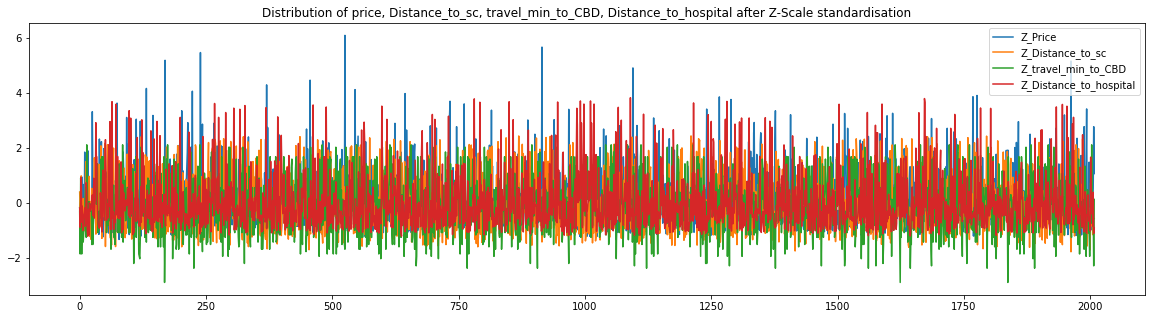

In [311]:
# Line graph shows the deviation of all four columns between mean = 0 and sd =1
price_model_data.Z_Price.plot(figsize=(20,5)
                              ,title='Distribution of price, Distance_to_sc, travel_min_to_CBD, Distance_to_hospital after Z-Scale standardisation'
                              ,label='Z_Price'
                             ,legend='upper right'),
price_model_data.Z_Distance_to_sc.plot(label='Z_Distance_to_sc'
                                      ,legend='upper right'),
price_model_data.Z_travel_min_to_CBD.plot(label='Z_travel_min_to_CBD'
                                         ,legend='upper right'),
price_model_data.Z_Distance_to_hospital.plot(label='Z_Distance_to_hospital',legend='upper right')

### 6.1.3 Check Normality and Linearity : distribution of all columns

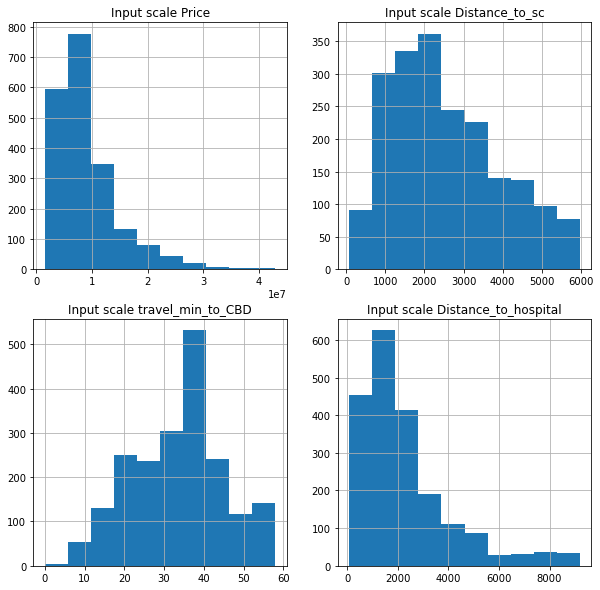

In [312]:
# Figure to check the distribution of price, Distance_to_sc, travel_min_to_CBD, Distance_to_hospital
fig, axs = plt.subplots(2, 2,figsize=(10,10))
axs[0, 0].hist(price_model_data.price)
axs[0, 0].set_title('Input scale Price')
axs[0, 0].grid()
axs[0, 1].hist(price_model_data.Distance_to_sc)
axs[0, 1].set_title('Input scale Distance_to_sc')
axs[0, 1].grid()
axs[1, 0].hist(price_model_data.travel_min_to_CBD)
axs[1, 0].set_title('Input scale travel_min_to_CBD')
axs[1, 0].grid()
axs[1, 1].hist(price_model_data.Distance_to_hospital)
axs[1, 1].set_title('Input scale Distance_to_hospital')
axs[1, 1].grid()

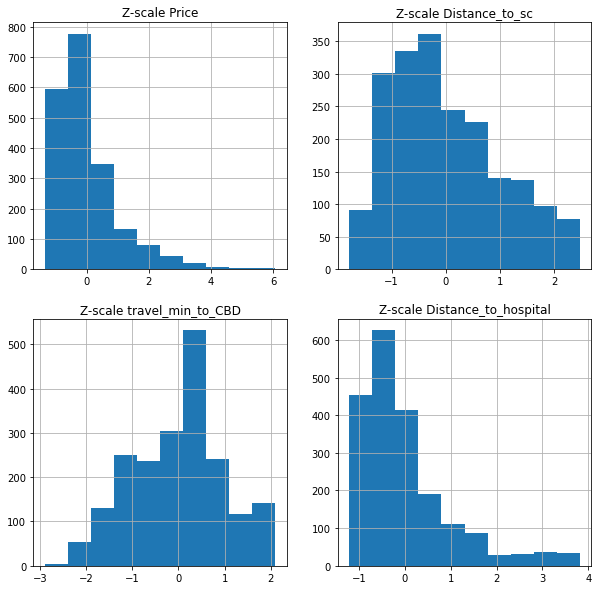

In [313]:
# Figure to check the distribution of price, Distance_to_sc, travel_min_to_CBD, Distance_to_hospital
fig, axs = plt.subplots(2, 2,figsize=(10,10))
axs[0, 0].hist(price_model_data.Z_Price)
axs[0, 0].set_title('Z-scale Price')
axs[0, 0].grid()
axs[0, 1].hist(price_model_data.Z_Distance_to_sc)
axs[0, 1].set_title('Z-scale Distance_to_sc')
axs[0, 1].grid()
axs[1, 0].hist(price_model_data.Z_travel_min_to_CBD)
axs[1, 0].set_title('Z-scale travel_min_to_CBD')
axs[1, 0].grid()
axs[1, 1].hist(price_model_data.Z_Distance_to_hospital)
axs[1, 1].set_title('Z-scale Distance_to_hospital')
axs[1, 1].grid()

#### Inference from distribution

1. From the histogram above, we can see that before and after standardisation we could see that the historgram has not changed.
2. **Price** and **Distance_to_hospital** is **right-skewed** this means that towards the end of the distribution there are fewer values.
3. **travel_min_to_CBD and Distance_to_sc** are closer to Gaussian distribution/Normal distribution.
4. We need to apply tranformation to Distance_to_hospital and Price to make it into Normal distrinution.


### 6.2 MinMax Normalisation:

This rescaling is similar to Zscale standardisation, here we will subtract minimum of a column with subtracted value of Maximum and minimum. Using this we will rescale the value of Price, Distance_to_hospital,travel_min_to_CBD and Distance_to_sc

In [314]:
# Standardised transform Using minmax
minmax_scale = preprocessing.MinMaxScaler().fit(price_model_data[['price', 'Distance_to_sc', 'travel_min_to_CBD', 'Distance_to_hospital']])
minmax_df = minmax_scale.transform(price_model_data[['price', 'Distance_to_sc', 'travel_min_to_CBD', 'Distance_to_hospital']])
minmax_df[0:5]

array([[0.15762834, 0.51102442, 0.51724138, 0.20293827],
       [0.1428778 , 0.3256445 , 0.20689655, 0.06391843],
       [0.10508556, 0.42639077, 0.75862069, 0.25074005],
       [0.04820439, 0.64857531, 0.63793103, 0.42396667],
       [0.30802603, 0.2240502 , 0.20689655, 0.10218178]])

In [315]:
# Store into  dataframe and view the difference.
price_model_data['MM_Price'] = minmax_df[:,0] # Scaled price
price_model_data['MM_Distance_to_sc'] = minmax_df[:,1] # scaled distance to shopping center
price_model_data['MM_travel_min_to_CBD'] = minmax_df[:,2] # scaled travel time
price_model_data['MM_Distance_to_hospital'] = minmax_df[:,3]# scaled distance to Hospital

### 6.2.1 Mean and SD before and After standardisation

In this section we can see that the columns 'price','Distance_to_sc','travel_min_to_CBD','Distance_to_hospital' are of different scales and metrics before doing the standardisation and the mean and standard deviation are extremely volatile before the standardisation is done. We can also see the Mean and SD is 0 and less than 1 respectively after the Min-Max Standardisation.

In [316]:
# Mean Before and after standardisation.
print('Mean before standardisation :\n Price: {:.2f}, Distance_to_sc: {:.2f}, travel_min_to_CBD: {:.2f}, Distance_to_hospital: {:.2f}'.format(price_model_data.price.mean()
                                               ,price_model_data.Distance_to_sc.mean()
                                               ,price_model_data.travel_min_to_CBD.mean()
                                               ,price_model_data.Distance_to_hospital.mean()))
print('Mean after standardisation :\n Z_Price: {:.2f}, Z_Distance_to_sc: {:.2f}, Z_travel_min_to_CBD: {:.2f}, Z_Distance_to_hospital: {:.2f}'.format(price_model_data.MM_Price.mean()
                                               ,price_model_data.MM_Distance_to_sc.mean()
                                               ,price_model_data.MM_travel_min_to_CBD.mean()
                                               ,price_model_data.MM_Distance_to_hospital.mean()))

Mean before standardisation :
 Price: 9054704.83, Distance_to_sc: 2548.10, travel_min_to_CBD: 33.61, Distance_to_hospital: 2281.90
Mean after standardisation :
 Z_Price: 0.18, Z_Distance_to_sc: 0.42, Z_travel_min_to_CBD: 0.58, Z_Distance_to_hospital: 0.24


In [317]:
# Standard deviation before and after zscale standardisation:

print('SD before standardisation :\n Price: {:.2f}, Distance_to_sc: {:.2f}, travel_min_to_CBD: {:.2f}, Distance_to_hospital: {:.2f}'.format(price_model_data.price.std()
                                               ,price_model_data.Distance_to_sc.std()
                                               ,price_model_data.travel_min_to_CBD.std()
                                               ,price_model_data.Distance_to_hospital.std()))
print('SD after standardisation :\n Z_Price: {:.2f}, Z_Distance_to_sc: {:.2f}, Z_travel_min_to_CBD: {:.2f}, Z_Distance_to_hospital: {:.2f}'.format(price_model_data.MM_Price.std()
                                               ,price_model_data.MM_Distance_to_sc.std()
                                               ,price_model_data.MM_travel_min_to_CBD.std()
                                               ,price_model_data.MM_Distance_to_hospital.std()))

SD before standardisation :
 Price: 5586293.66, Distance_to_sc: 1386.69, travel_min_to_CBD: 11.60, Distance_to_hospital: 1813.32
SD after standardisation :
 Z_Price: 0.13, Z_Distance_to_sc: 0.24, Z_travel_min_to_CBD: 0.20, Z_Distance_to_hospital: 0.20


### 6.2.3 Check Normality : Min-Max distribution of all columns

In this section we will check both the Linearity and Normal aspect of the columns before and after standardisation and infer important information on the effect these standardisation has on the the data in these columns.

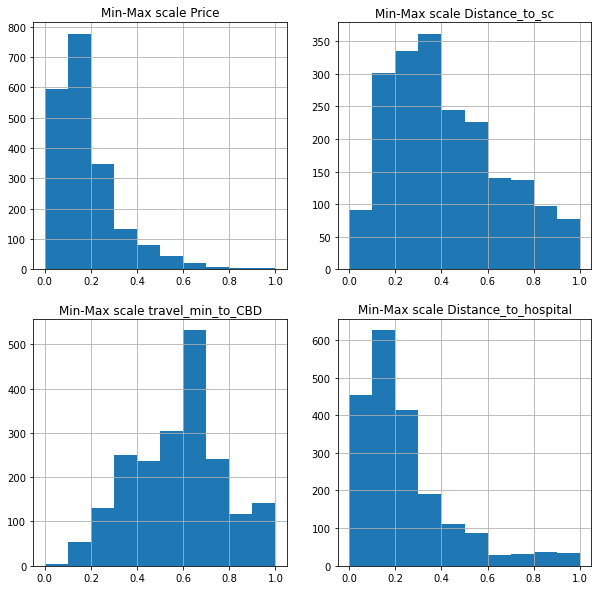

In [318]:
# Figure to check the distribution of price, Distance_to_sc, travel_min_to_CBD, Distance_to_hospital
fig, axs = plt.subplots(2, 2,figsize=(10,10))
axs[0, 0].hist(price_model_data.MM_Price)
axs[0, 0].set_title('Min-Max scale Price')
axs[0, 0].grid()
axs[0, 1].hist(price_model_data.MM_Distance_to_sc)
axs[0, 1].set_title('Min-Max scale Distance_to_sc')
axs[0, 1].grid()
axs[1, 0].hist(price_model_data.MM_travel_min_to_CBD)
axs[1, 0].set_title('Min-Max scale travel_min_to_CBD')
axs[1, 0].grid()
axs[1, 1].hist(price_model_data.MM_Distance_to_hospital)
axs[1, 1].set_title('Min-Max scale Distance_to_hospital')
axs[1, 1].grid()

We can see that from the histograms shown above, Input scale, Z scale and Min-Max scale standardisation do not change the distribution of predictors. **Price and Distance_to_Hospital** is still **right skewed**

### 6.2.4 Check Linearity : distribution of Distance_to_sc, travel_min_to_CBD, Distance_to_hospital with Y= Price

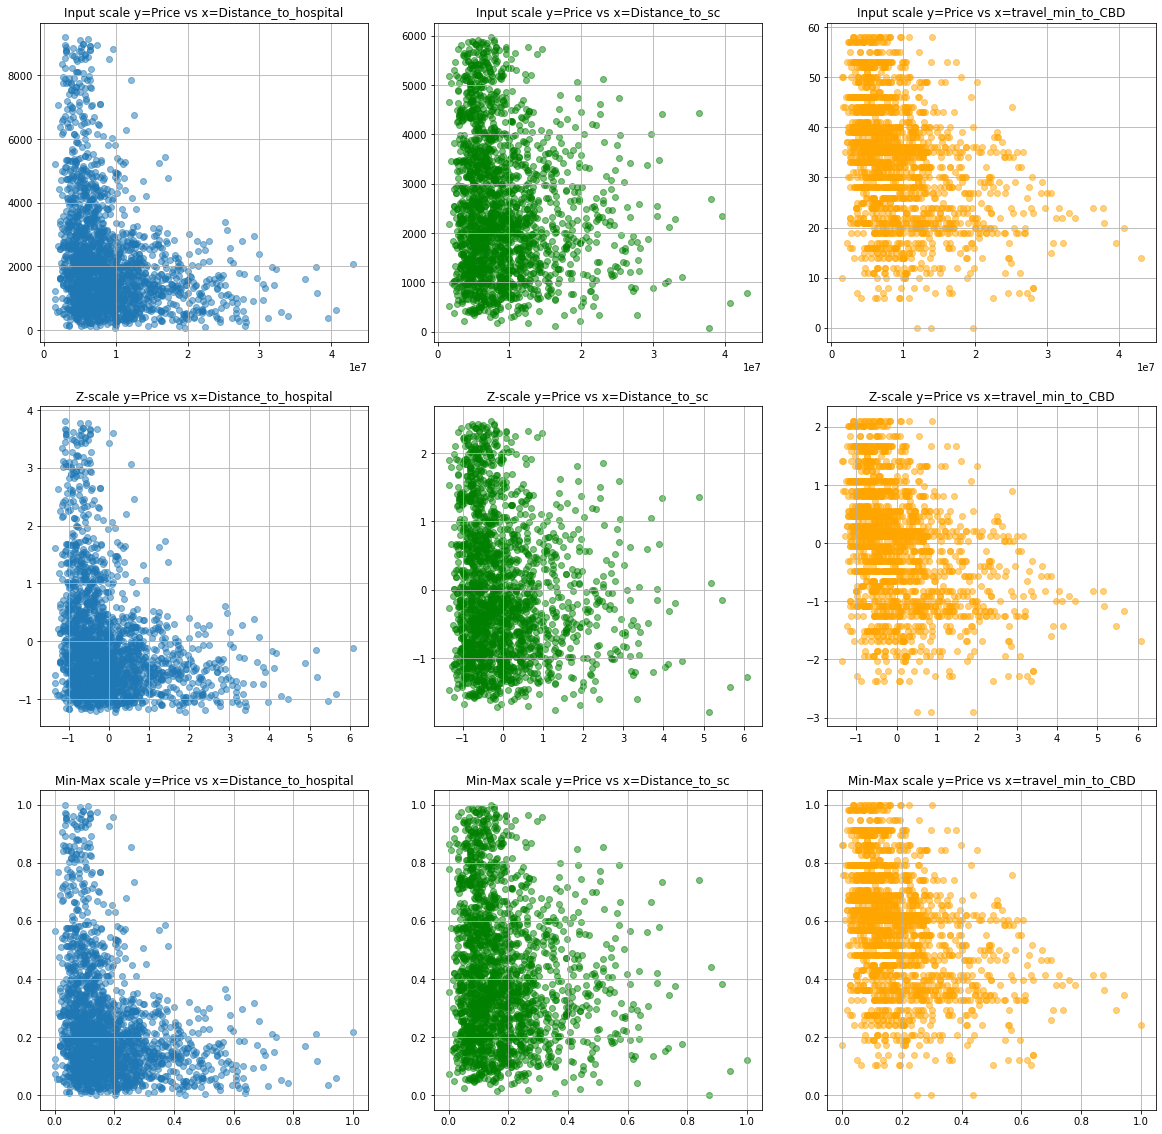

In [319]:
# Create a Figure of size 20, 20 to plot the graphs.
fig, axs = plt.subplots(3, 3,figsize=(20,20))

# use axs to denote where the plot is drawn.
# input scale with out any standardisation.
axs[0, 0].scatter(price_model_data.price,price_model_data.Distance_to_hospital,alpha=0.5)
axs[0, 0].set_title('Input scale y=Price vs x=Distance_to_hospital')
axs[0, 0].grid()
axs[0, 1].scatter(price_model_data.price,price_model_data.Distance_to_sc,alpha=0.5, color='green')
axs[0, 1].set_title('Input scale y=Price vs x=Distance_to_sc')
axs[0, 1].grid()
axs[0, 2].scatter(price_model_data.price,price_model_data.travel_min_to_CBD,alpha=0.5, color='orange')
axs[0, 2].set_title('Input scale y=Price vs x=travel_min_to_CBD')
axs[0, 2].grid()

# Z-scale standardasation on all columns.
axs[1, 0].scatter(price_model_data.Z_Price,price_model_data.Z_Distance_to_hospital,alpha=0.5)
axs[1, 0].set_title('Z-scale y=Price vs x=Distance_to_hospital')
axs[1, 0].grid()
axs[1, 1].scatter(price_model_data.Z_Price,price_model_data.Z_Distance_to_sc,alpha=0.5, color='green')
axs[1, 1].set_title('Z-scale y=Price vs x=Distance_to_sc')
axs[1, 1].grid()
axs[1, 2].scatter(price_model_data.Z_Price,price_model_data.Z_travel_min_to_CBD,alpha=0.5, color='orange')
axs[1, 2].set_title('Z-scale y=Price vs x=travel_min_to_CBD')
axs[1, 2].grid()

# minmax standardasation on all columns.
axs[2, 0].scatter(price_model_data.MM_Price,price_model_data.MM_Distance_to_hospital,alpha=0.5)
axs[2, 0].set_title('Min-Max scale y=Price vs x=Distance_to_hospital')
axs[2, 0].grid()
axs[2, 1].scatter(price_model_data.MM_Price,price_model_data.MM_Distance_to_sc,alpha=0.5, color='green')
axs[2, 1].set_title('Min-Max scale y=Price vs x=Distance_to_sc')
axs[2, 1].grid()
axs[2, 2].scatter(price_model_data.MM_Price,price_model_data.MM_travel_min_to_CBD,alpha=0.5, color='orange')
axs[2, 2].set_title('Min-Max scale y=Price vs x=travel_min_to_CBD')
axs[2, 2].grid()


#### 6.2.5 Inference from graph

* From this scatter plot above we can see that even though standardisation has been done to price, Distance_to_sc, travel_min_to_CBD, Distance_to_hospital columns, the distribution remains the same. There is no loss of information to the overall spread of data.
* When creating the linear regression model the coefficients of Distance_to_sc, travel_min_to_CBD, Distance_to_hospital as predictors will denote the contribution of a predictor in predicting Price.
* Initially the scale of all the columns where different and after performing the standardisation columns are either within mean =0 and sd=1 or within min=0 or max=1.
* Using Z-scale or Min-Max to create the model will help understand the linearlity aspect of Distance_to_sc, travel_min_to_CBD, Distance_to_hospital better.

## 7.Data Transformation to check normality and linearity

In order make sure that the normality condition of lineat regression is met we will to make changes/ tranformation to predictor and check if applying the following transformation makes the predictors ditribution into normal/guassian. We will apply the following transformations.

* Root Transformation
* Square/Power Transformation
* Log transformation 
* Box-Cox transformation


Of all the predictors we could see from the histogram that **Price and Distance_to_Hospital** are **right skewed** and we will apply the transformation to these fields and see the changes mainly, however we would still want to see if there are any changes to normality for travel_min_to_CBD and Distance_to_sc after applying these transformations.


### 7.1 Root transformation.

This transformation is lossy in nature, meaning once the date is converted to root form the original information is now in a different dimension on which the relationship and pattern is studied. In most cases this can be use to fix right skewed data.

In [320]:
price_model_data

,price,Distance_to_sc,travel_min_to_CBD,Distance_to_hospital,Z_Price,Z_Distance_to_sc,Z_travel_min_to_CBD,Z_Distance_to_hospital,MM_Price,MM_Distance_to_sc,MM_travel_min_to_CBD,MM_Distance_to_hospital
0,8060000.0,3088.0,30.0,1926.0,-0.178106,0.389442,-0.311319,-0.196318,0.157628,0.511024,0.517241,0.202938
1,7448000.0,1995.0,12.0,658.0,-0.287687,-0.398962,-1.862854,-0.895761,0.142878,0.325645,0.206897,0.063918
2,5880000.0,2589.0,44.0,2362.0,-0.568444,0.029503,0.895430,0.044185,0.105086,0.426391,0.758621,0.250740
3,3520000.0,3899.0,37.0,3942.0,-0.991012,0.974434,0.292055,0.915730,0.048204,0.648575,0.637931,0.423967
4,14300000.0,1396.0,12.0,1007.0,0.939192,-0.831034,-1.862854,-0.703248,0.308026,0.224050,0.206897,0.102182
...,...,...,...,...,...,...,...,...,...,...,...,...
2004,3510000.0,1918.0,30.0,2267.0,-0.992802,-0.454504,-0.311319,-0.008218,0.047963,0.312585,0.517241,0.240325
2005,9010000.0,936.0,24.0,744.0,-0.008005,-1.162841,-0.828498,-0.848322,0.180525,0.146031,0.413793,0.073347
2006,12000000.0,2480.0,29.0,2972.0,0.527367,-0.049121,-0.397516,0.380667,0.252591,0.407904,0.500000,0.317619
2007,24480000.0,1751.0,7.0,252.0,2.761963,-0.574964,-2.293836,-1.119715,0.553386,0.284261,0.120690,0.019406


#### Perform root transformation on columns.

In [321]:
# using the Numpy sqrt function create new columns.
price_model_data['root_price']=np.sqrt(price_model_data.price)
price_model_data['root_Distance_to_sc']=np.sqrt(price_model_data.Distance_to_sc)
price_model_data['root_travel_min_to_CBD']=np.sqrt(price_model_data.travel_min_to_CBD)
price_model_data['root_Distance_to_hospital']=np.sqrt(price_model_data.Distance_to_hospital)


#### Check Normality and Linearity after Root Tranformation on all columns

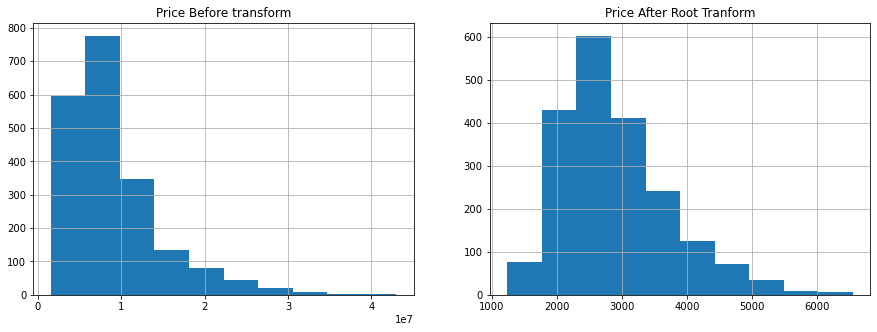

In [322]:
# PRICE before and after root transformation. Normality
fig, axs = plt.subplots(1, 2,figsize=(15,5))
axs[0].hist(price_model_data['price'])
axs[0].set_title('Price Before transform')
axs[0].grid()
axs[1].hist(price_model_data['root_price'])
axs[1].set_title('Price After Root Tranform')
axs[1].grid()


The right skew is has reduced and the data seems to look a lot like Normal distribution as Price is transformed into root of price. Also the scale seems to reduced and looks more interpretable compared to Input Price field. It is worth noting that if we used Min-Max price or Z-scale stadardised price and applied the root transformation the data of input will still be right skewed and the transformed data will look a lot closer to normal distribution. 

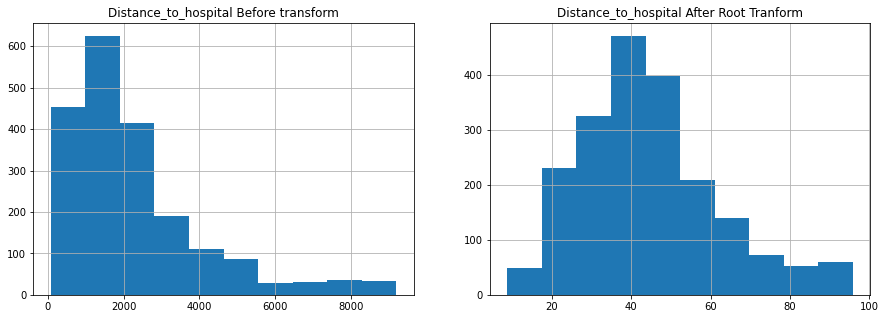

In [323]:
# Distance_to_hospital before and after root transformation.
fig, axs = plt.subplots(1, 2,figsize=(15,5))
axs[0].hist(price_model_data['Distance_to_hospital'])
axs[0].set_title('Distance_to_hospital Before transform')
axs[0].grid()
axs[1].hist(price_model_data['root_Distance_to_hospital'])
axs[1].set_title('Distance_to_hospital After Root Tranform')
axs[1].grid()


Similar to Price, applying root transformation on Distance_to_hospital column has removed the right skew from this predictor and transfored data looks a lot closed to normal. It is worth to keep root transformation in mind while developing the linear model for both Price and distance_to Hospital columns.

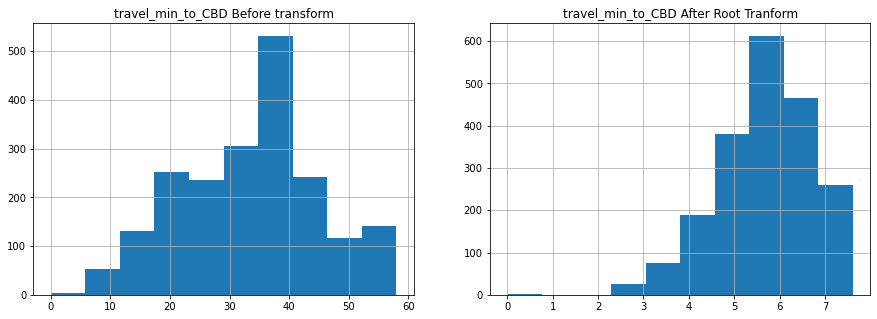

In [324]:
# travel_min_to_CBD before and after root transformation.
fig, axs = plt.subplots(1, 2,figsize=(15,5))
axs[0].hist(price_model_data['travel_min_to_CBD'])
axs[0].set_title('travel_min_to_CBD Before transform')
axs[0].grid()
axs[1].hist(price_model_data['root_travel_min_to_CBD'])
axs[1].set_title('travel_min_to_CBD After Root Tranform')
axs[1].grid()


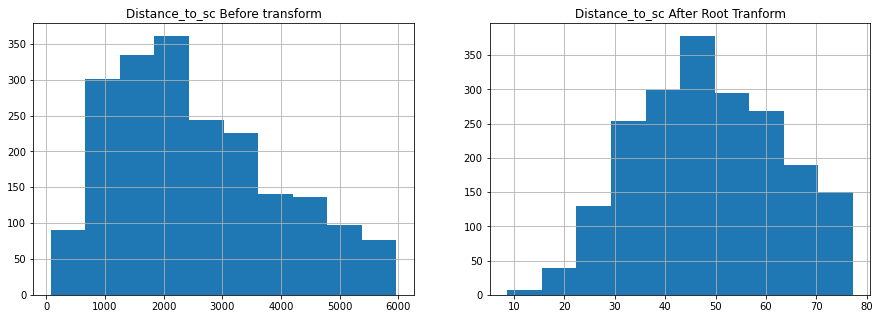

In [325]:
# travel_min_to_CBD before and after root transformation.
fig, axs = plt.subplots(1, 2,figsize=(15,5))
axs[0].hist(price_model_data['Distance_to_sc'])
axs[0].set_title('Distance_to_sc Before transform')
axs[0].grid()
axs[1].hist(price_model_data['root_Distance_to_sc'])
axs[1].set_title('Distance_to_sc After Root Tranform')
axs[1].grid()


#### Check linearity

we will plot a scatter plot and understand if there is improvement to columns after performing root tranformation. Although Normality is improved by using Root tranformation we need to understand if the linearity is improved compated to the initial spread of data.


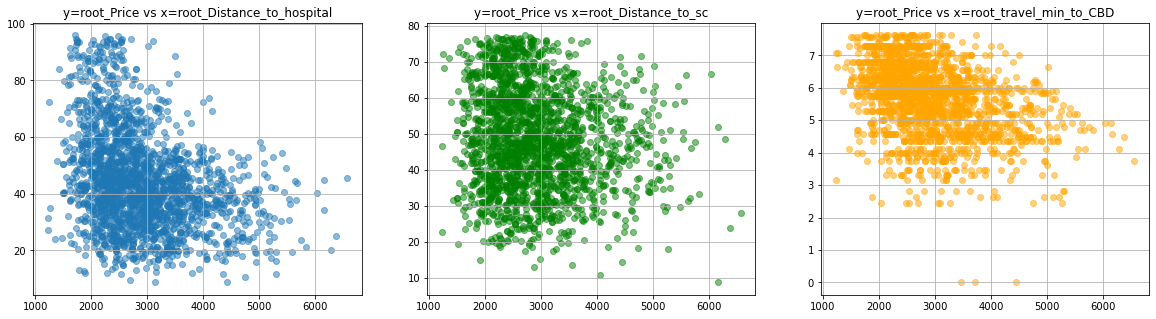

In [326]:
# Create a Figure of size 20, 20 to plot the graphs.
fig, axs = plt.subplots(1, 3,figsize=(20,5))

# use axs to denote where the plot is drawn.
# input scale with out any standardisation.
axs[0].scatter(price_model_data.root_price,price_model_data.root_Distance_to_hospital,alpha=0.5)
axs[0].set_title('y=root_Price vs x=root_Distance_to_hospital')
axs[0].grid()
axs[1].scatter(price_model_data.root_price,price_model_data.root_Distance_to_sc,alpha=0.5, color='green')
axs[1].set_title('y=root_Price vs x=root_Distance_to_sc')
axs[1].grid()
axs[2].scatter(price_model_data.root_price,price_model_data.root_travel_min_to_CBD,alpha=0.5, color='orange')
axs[2].set_title('y=root_Price vs x=root_travel_min_to_CBD')
axs[2].grid()

#### Inference from Root transformation.

1. Applying root transformation is certainly a good option for right skewed columns Price and Distance_to_Hospital.
2. It is worth to note that Normality is better using Root transformation on Distance_to_sc and travel_min_to_CBD. This is because Root reduce the peaks and levels the columns making it appear more normal.
3. Linearity has taken a hit by using root transformation and there are no visible linear patterns between transfored predictors, which is an important assumption for linear regression model(linear additive summation). 


### 7.2 Power transformation.

Power transformation helps to amplify the data where there are uneven spread to data. In our predictors as there right skewed information this will worsen the spread and mostly likely be a bad choice to transform the data.

#### Perform root transformation on columns.

In [327]:
# using the Numpy power function create new columns.
price_model_data['pow_price']=np.power(price_model_data.price,2)
price_model_data['pow_Distance_to_sc']=np.power(price_model_data.Distance_to_sc,2)
price_model_data['pow_travel_min_to_CBD']=np.power(price_model_data.travel_min_to_CBD,2)
price_model_data['pow_Distance_to_hospital']=np.power(price_model_data.Distance_to_hospital,2)

#### Check Normality and Linearity after Root Tranformation on all columns

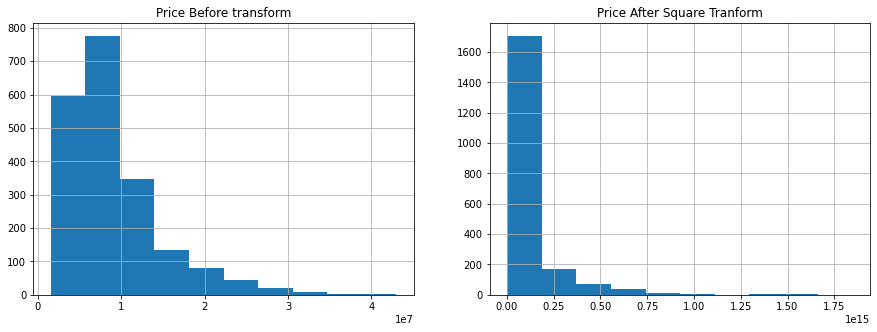

In [328]:
# PRICE before and after square transformation. Normality
fig, axs = plt.subplots(1, 2,figsize=(15,5))
axs[0].hist(price_model_data['price'])
axs[0].set_title('Price Before transform')
axs[0].grid()
axs[1].hist(price_model_data['pow_price'])
axs[1].set_title('Price After Square Tranform')
axs[1].grid()

We can see that the right skew has worsened after applying power transformation on already right skewed data. distance_to_Hospital will have the same effect as this columns is also right skewed. We will still compare the effect on travel_min_to_CBD and Distance_to_sc.

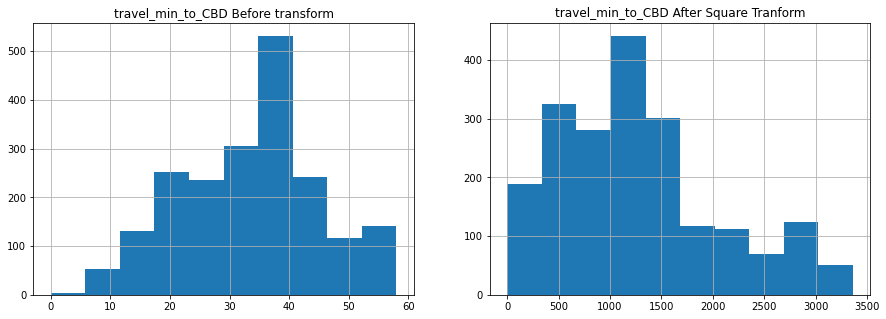

In [329]:
# travel_min_to_CBD before and after square transformation.
fig, axs = plt.subplots(1, 2,figsize=(15,5))
axs[0].hist(price_model_data['travel_min_to_CBD'])
axs[0].set_title('travel_min_to_CBD Before transform')
axs[0].grid()
axs[1].hist(price_model_data['pow_travel_min_to_CBD'])
axs[1].set_title('travel_min_to_CBD After Square Tranform')
axs[1].grid()

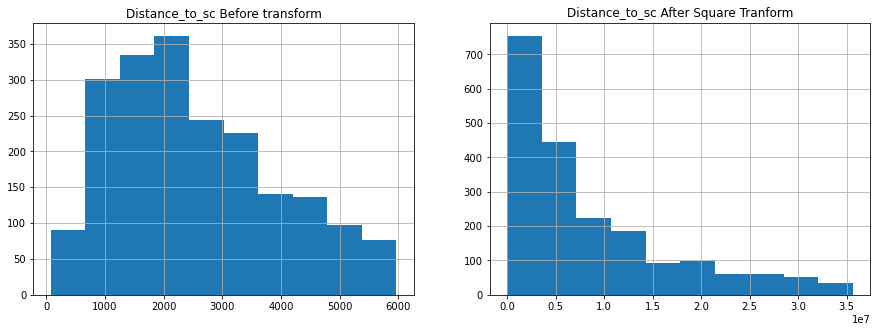

In [330]:
# travel_min_to_CBD before and after square transformation.
fig, axs = plt.subplots(1, 2,figsize=(15,5))
axs[0].hist(price_model_data['Distance_to_sc'])
axs[0].set_title('Distance_to_sc Before transform')
axs[0].grid()
axs[1].hist(price_model_data['pow_Distance_to_sc'])
axs[1].set_title('Distance_to_sc After Square Tranform')
axs[1].grid()

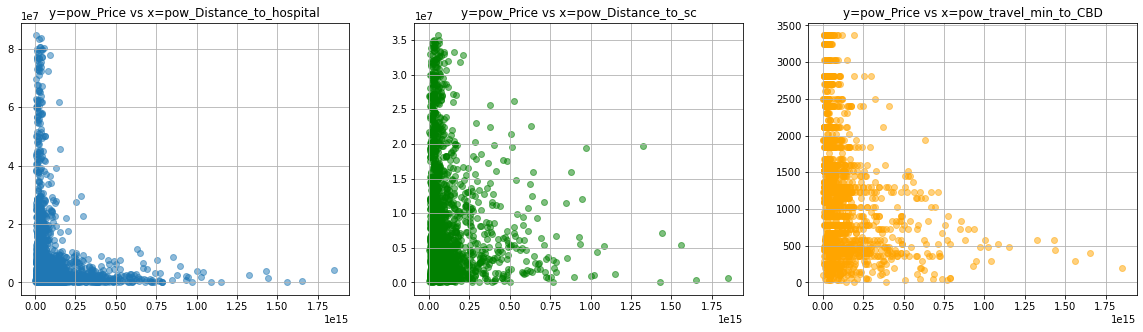

In [331]:
# Create a Figure of size 20, 20 to plot the graphs.
fig, axs = plt.subplots(1, 3,figsize=(20,5))

# use axs to denote where the plot is drawn.
# input scale with out any standardisation.
axs[0].scatter(price_model_data.pow_price,price_model_data.pow_Distance_to_hospital,alpha=0.5)
axs[0].set_title('y=pow_Price vs x=pow_Distance_to_hospital')
axs[0].grid()
axs[1].scatter(price_model_data.pow_price,price_model_data.pow_Distance_to_sc,alpha=0.5, color='green')
axs[1].set_title('y=pow_Price vs x=pow_Distance_to_sc')
axs[1].grid()
axs[2].scatter(price_model_data.pow_price,price_model_data.pow_travel_min_to_CBD,alpha=0.5, color='orange')
axs[2].set_title('y=pow_Price vs x=pow_travel_min_to_CBD')
axs[2].grid()

#### Inference from Square transformation.

1. Right skewed data becomes more right skewed which make this transformation useless to make columns to normal.
2. Linerity has not improved using the square transformation for these columns.

### 7.3 Log transformation.

Log transformation is handy in handling right skewed data as the log of huge numbers are smaller this way the distribution becomes close to normal. Its work noting that there is no value defined for 0 , so in order to make sure log runs without any issues we will subsitite a very small value rows with 0 in them. Also there are many log that can be applied to data like log to base 2, log to base 10, natural log. Here we will use natural log.

#### Update zero in columns as log 0 is not defined.

In [332]:
# subsitute small value close to zero like 0.00001 as log(0) is undefined.
price_model_data.price.loc[(price_model_data.price == 0)]=0.00001
price_model_data.Distance_to_sc.loc[(price_model_data.Distance_to_sc == 0)]=0.00001
price_model_data.Distance_to_hospital.loc[(price_model_data.Distance_to_hospital == 0)]=0.00001
price_model_data.travel_min_to_CBD.loc[(price_model_data.travel_min_to_CBD == 0)]=0.00001

#### Perform root transformation on columns.

In [333]:
# using the Numpy log function create new columns.
price_model_data['log_price']=np.log(price_model_data.price)
price_model_data['log_Distance_to_sc']=np.log(price_model_data.Distance_to_sc,)
price_model_data['log_travel_min_to_CBD']=np.log(price_model_data.travel_min_to_CBD)
price_model_data['log_Distance_to_hospital']=np.log(price_model_data.Distance_to_hospital)

#### Visualization of before and after log transformation.

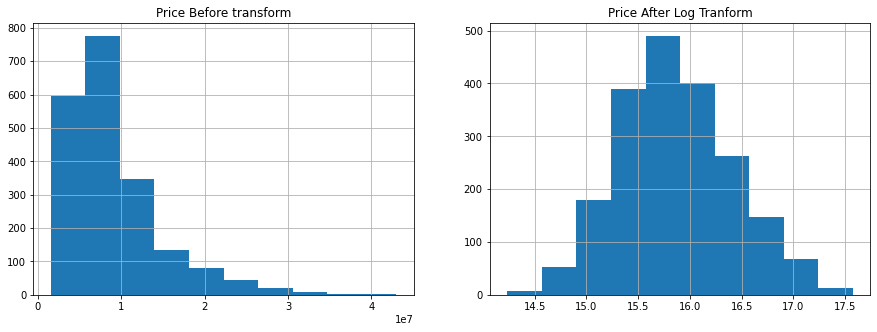

In [334]:
# PRICE before and after log transformation. Normality
fig, axs = plt.subplots(1, 2,figsize=(15,5))
axs[0].hist(price_model_data['price'])
axs[0].set_title('Price Before transform')
axs[0].grid()
axs[1].hist(price_model_data['log_price'])
axs[1].set_title('Price After Log Tranform')
axs[1].grid()

It clearly evident the right skewness removed by using the log, in this case natural log. Price data is transformed into normal distribution after applying log transformation on it. We will do the same to other right skewed data.

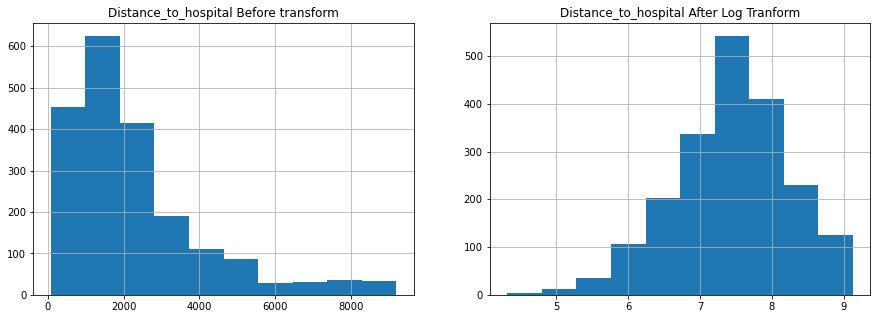

In [335]:
# Distance_to_hospital before and after log transformation.
fig, axs = plt.subplots(1, 2,figsize=(15,5))
axs[0].hist(price_model_data['Distance_to_hospital'])
axs[0].set_title('Distance_to_hospital Before transform')
axs[0].grid()
axs[1].hist(price_model_data['log_Distance_to_hospital'])
axs[1].set_title('Distance_to_hospital After Log Tranform')
axs[1].grid()


Similary to price, distance_to_hospital column is transfored into a normal distribution by applying log transformation.
This is much better than root transformation as the ditribution is almost normal/ gaussian which is needed to create the linear model.

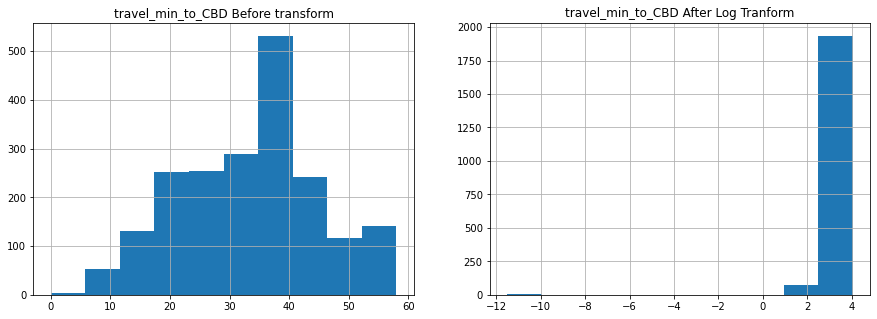

In [336]:
# travel_min_to_CBD before and after square transformation.
fig, axs = plt.subplots(1, 2,figsize=(15,5))
axs[0].hist(price_model_data['travel_min_to_CBD'])
axs[0].set_title('travel_min_to_CBD Before transform')
axs[0].grid()
axs[1].hist(price_model_data['log_travel_min_to_CBD'])
axs[1].set_title('travel_min_to_CBD After Log Tranform')
axs[1].grid()

It is evident that using log transformation on travel_min_to_CBD columns has adverse effect, this transforms the data to left skewed which makes this not feasible for travel_min_to_CBD predictor.

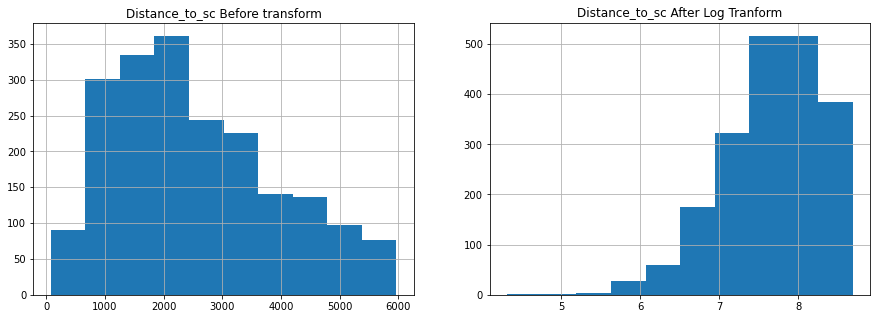

In [337]:
# travel_min_to_CBD before and after square transformation.
fig, axs = plt.subplots(1, 2,figsize=(15,5))
axs[0].hist(price_model_data['Distance_to_sc'])
axs[0].set_title('Distance_to_sc Before transform')
axs[0].grid()
axs[1].hist(price_model_data['log_Distance_to_sc'])
axs[1].set_title('Distance_to_sc After Log Tranform')
axs[1].grid()

For Distance_to_sc which was right heavy right tailed get converted into almost normal distribution using the log transformation. 

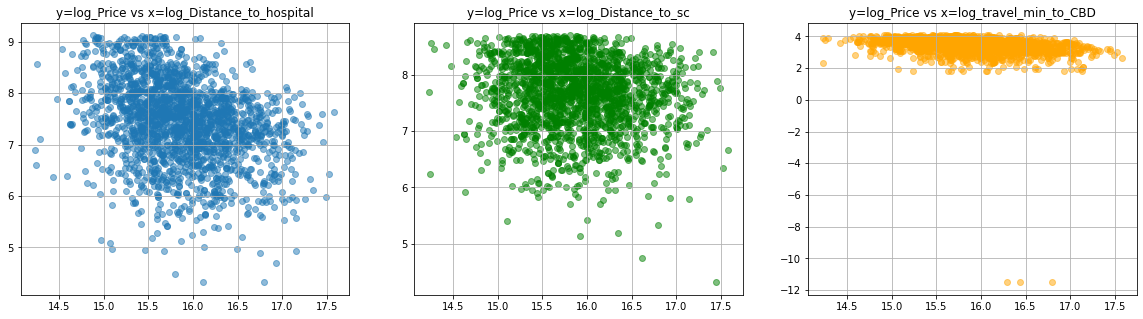

In [338]:
# Check for Linearity.
# Create a Figure of size 20, 20 to plot the graphs. 
fig, axs = plt.subplots(1, 3,figsize=(20,5))

# use axs to denote where the plot is drawn.
# input scale with out any standardisation.
axs[0].scatter(price_model_data.log_price,price_model_data.log_Distance_to_hospital,alpha=0.5)
axs[0].set_title('y=log_Price vs x=log_Distance_to_hospital')
axs[0].grid()
axs[1].scatter(price_model_data.log_price,price_model_data.log_Distance_to_sc,alpha=0.5, color='green')
axs[1].set_title('y=log_Price vs x=log_Distance_to_sc')
axs[1].grid()
axs[2].scatter(price_model_data.log_price,price_model_data.log_travel_min_to_CBD,alpha=0.5, color='orange')
axs[2].set_title('y=log_Price vs x=log_travel_min_to_CBD')
axs[2].grid()

#### Inference from Log transformation.

1. Normality is restored using Log transformation on right skewed data, this includes Price, Distance_to_hospital and Distance_to_sc. 
2. travel_min_to_CBD tranformed into Leftskewed which incidcates this should not be applied to this predictor.
3. There is no evidence on linearity although data is evenly spread for log of predictor with log of price.

### 7.4 Box-Cox transformation.

Right skewed data or power law function which has heavy tails to the right and high peaks on the left can be easily converted to normal/guassian distribution using the box-cox transformation. We will apply this transformation on Price, Distance_to_Hospital, Distance_to_Sc and Travel_time_CBD columns and understand the effect of this transformation on them. In mathematical terms it is given by 

$\large y(\lambda)=\Large\frac{y^\lambda-1}{\lambda}$ for $\lambda\neq0$ this function converges to Log(y) if $\lambda=0$

IMPORTANT: For box_cox to work the data points should be positive and it does not work otherwise. All our data points are positive and we wont have any problems in implementing this. We cannot have log(0) so we will include a small value close to 0 like 0.00001 to 0 values in all the columns before applying box cox tranformation.

#### Perform root transformation on columns.

In [339]:
# using the Numpy log function create new columns.
price_model_data['box_price'],l1=stats.boxcox(price_model_data.price)
price_model_data['box_Distance_to_sc'],l2=stats.boxcox(price_model_data.Distance_to_sc)
price_model_data['box_travel_min_to_CBD'],l3=stats.boxcox(price_model_data.travel_min_to_CBD)
price_model_data['box_Distance_to_hospital'],l4=stats.boxcox(price_model_data.Distance_to_hospital)

#### Display Lambda values after transformation.

In [340]:
# Display lambda values for columns.
print( 'Lambda for Box-Cox transformation is given below:', '\nprice:',l1,'\nDistance_to_sc:',l2,'\ntravel_min_to_CBD:',l3,'\nDistance_to_hospital:',l4)

Lambda for Box-Cox transformation is given below: 
price: -0.1533641549646654 
Distance_to_sc: 0.4251326623850914 
travel_min_to_CBD: 0.9105135566871687 
Distance_to_hospital: 0.14732285948614965


#### Visualization of before and after Box-Cox transformation.

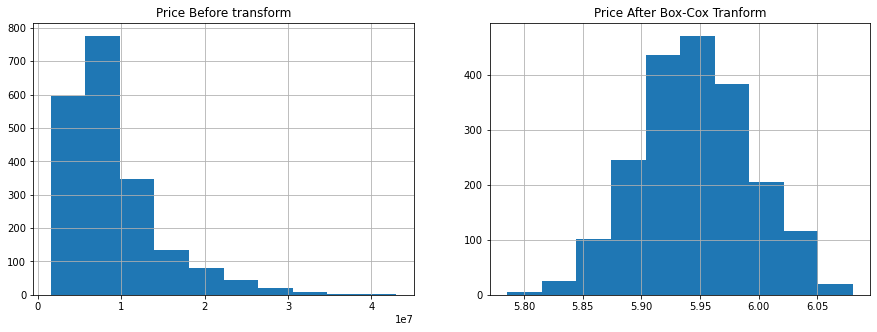

In [341]:
# PRICE before and after Box-Cox transformation. Normality
fig, axs = plt.subplots(1, 2,figsize=(15,5))
axs[0].hist(price_model_data['price'])
axs[0].set_title('Price Before transform')
axs[0].grid()
axs[1].hist(price_model_data['box_price'])
axs[1].set_title('Price After Box-Cox Tranform')
axs[1].grid()

On comparision to log transformation box-cox transformation is able to tranform the rightskewed Price column data into a Gaussian/Normal distribution. We will apply the same to distance_to_Hospital which is also right-Skewed.

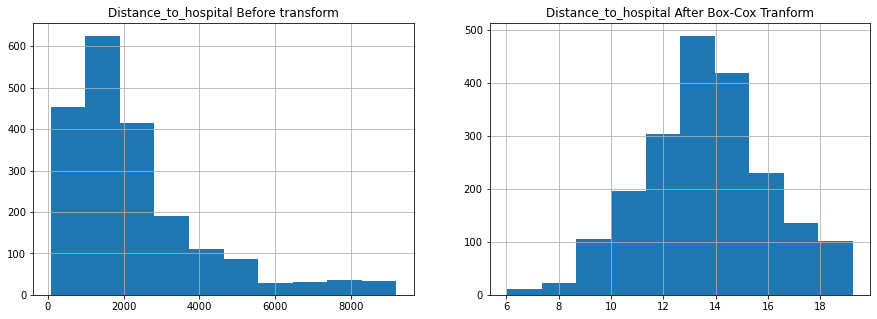

In [342]:
# Distance_to_hospital before and after Box-Cox transformation.
fig, axs = plt.subplots(1, 2,figsize=(15,5))
axs[0].hist(price_model_data['Distance_to_hospital'])
axs[0].set_title('Distance_to_hospital Before transform')
axs[0].grid()
axs[1].hist(price_model_data['box_Distance_to_hospital'])
axs[1].set_title('Distance_to_hospital After Box-Cox Tranform')
axs[1].grid()


Box-Cox transformation on distance_to_Hospital is also very close to normal distribution. We will use this transformed data while building the linear model.

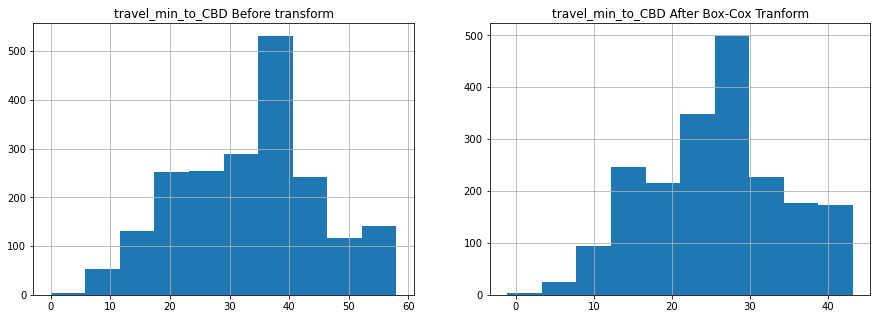

In [343]:
# travel_min_to_CBD before and after Box-Cox transformation.
fig, axs = plt.subplots(1, 2,figsize=(15,5))
axs[0].hist(price_model_data['travel_min_to_CBD'])
axs[0].set_title('travel_min_to_CBD Before transform')
axs[0].grid()
axs[1].hist(price_model_data['box_travel_min_to_CBD'])
axs[1].set_title('travel_min_to_CBD After Box-Cox Tranform')
axs[1].grid()

There is significant difference to distribution of travel_min_to_CBD which had high peak after Box-Cox tranformation the data is evenly distributed and looks more like a normal distribution.

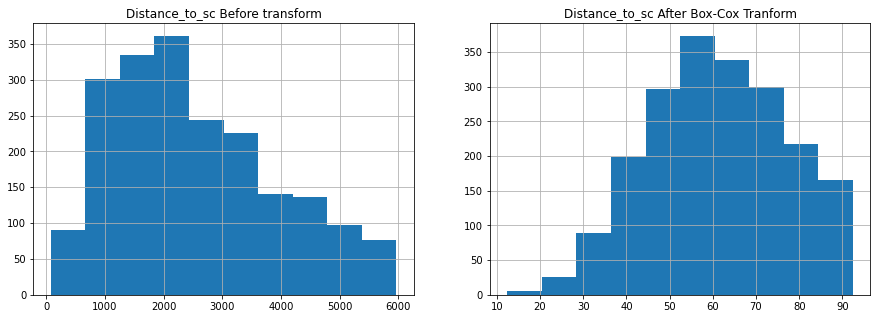

In [344]:
# travel_min_to_CBD before and after Box-Cox transformation.
fig, axs = plt.subplots(1, 2,figsize=(15,5))
axs[0].hist(price_model_data['Distance_to_sc'])
axs[0].set_title('Distance_to_sc Before transform')
axs[0].grid()
axs[1].hist(price_model_data['box_Distance_to_sc'])
axs[1].set_title('Distance_to_sc After Box-Cox Tranform')
axs[1].grid()

The right skew that was visible with the input scale of Distance_to_SC is absent in Box-Cox tranformed data. Tranformed data looks more Normal/Guassian which notes that on comparision to all tranformation done previously box-cox is highly effective in converting right-skewed data to more normally distributed.

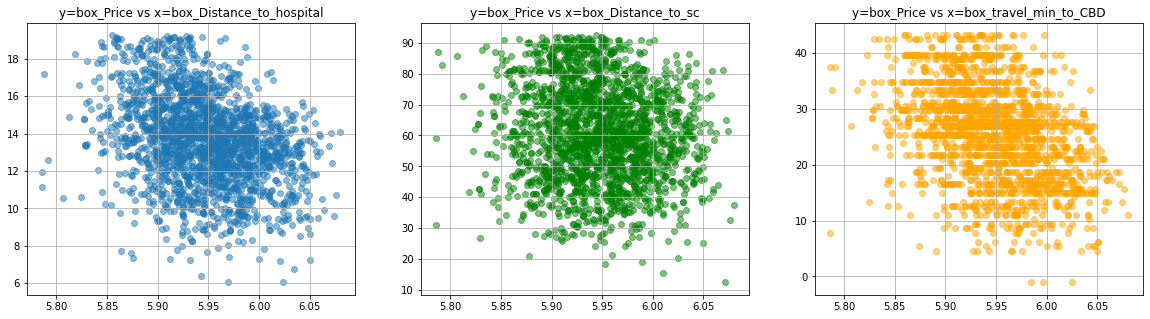

In [345]:
# Check for Linearity.
# Create a Figure of size 20, 20 to plot the graphs. 
fig, axs = plt.subplots(1, 3,figsize=(20,5))

# use axs to denote where the plot is drawn.
# input scale with out any standardisation.
axs[0].scatter(price_model_data.box_price,price_model_data.box_Distance_to_hospital,alpha=0.5)
axs[0].set_title('y=box_Price vs x=box_Distance_to_hospital')
axs[0].grid()
axs[1].scatter(price_model_data.box_price,price_model_data.box_Distance_to_sc,alpha=0.5, color='green')
axs[1].set_title('y=box_Price vs x=box_Distance_to_sc')
axs[1].grid()
axs[2].scatter(price_model_data.box_price,price_model_data.box_travel_min_to_CBD,alpha=0.5, color='orange')
axs[2].set_title('y=box_Price vs x=box_travel_min_to_CBD')
axs[2].grid()

#### Inference from Box-Cox transformation.

1. On comparision with all the tranforamtion, root, square/power, Log , Box-Cox is able to completely convert the right skewed data to a almost normal distribution. The normality of columns is acheived by using Box-Cox tranformation which is recommended to be used while developing the linear model.
2. Linearity is still unclear as non of the transformation is able to clearly provide a linear relationship with Price. This could mean that the linearity may be acheived while using better features or doing feature engineering that helps to identify tranformed feature that could add value to linear model.

## Reference

1. Pandas-read-xml. (n.d.). Retrieved from https://pypi.org/project/pandas-read-xml/ 
2. Varun. (2019, January 11). Pandas : How to create an empty DataFrame and append rows & columns to it in python. Retrieved from https://thispointer.com/pandas-how-to-create-an-empty-dataframe-and-append-rows-columns-to-it-in-python/ 
3. Pulo, N., Bugis, R. A., & Jamak, A. (2020, April 24). Importance and goals of filtering GTFS. Retrieved from https://www.atlantbh.com/importance-and-goals-of-filtering-gtfs/ 
4. Reference  |  Static Transit  |  Google Developers. (n.d.). Retrieved from https://developers.google.com/transit/gtfs/reference#tripstxt 
5. Point in Polygon & Intersect¶. (n.d.). Retrieved from https://automating-gis-processes.github.io/2016/Lesson3-point-in-polygon.html 
6. Soma, J. (Director). (n.d.). Spatial joins in geopandas [Video file]. Retrieved from https://www.youtube.com/watch?v=y85IKthrV-s&feature=youtu.be 
7. Bigbugbigbug 36.4k3434 gold badges6969 silver badges9191 bronze badges, GarrettGarrett 32.4k55 gold badges5151 silver badges4747 bronze badges, Cs95cs95 240k6262 gold badges414414 silver badges479479 bronze badges, JeffJeff 102k1717 gold badges190190 silver badges163163 bronze badges, Firelynxfirelynx 22.6k44 gold badges7878 silver badges8787 bronze badges, User443854user443854 5, . . . M-dzm-dz 2. (1963, February 01). How to deal with SettingWithCopyWarning in Pandas. Retrieved from https://stackoverflow.com/questions/20625582/how-to-deal-with-settingwithcopywarning-in-pandas 
8. Scipy.stats.boxcox. (n.d.). Retrieved from https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.boxcox.html 
9. Australia Victoria. (2016, January 31). Retrieved from https://en.wikipedia.org/wiki/Module:Location_map/data/Australia_Victoria
10. Managing Projections. (n.d.). Retrieved from https://geopandas.org/projections.html 